### Banking Discipline and Elasticity
J M Applegate.
##### CAS543 Complexity Economics
The notebook presents basic banking discipline and elasticity dynamics.  
A set of $n$ of retail customers are served by $N$ banks.  
Banks hold reserves as a central bank according to a specified reserve requirement.  
Customer transactions take place every day, and every night the reserve accounts need to be non-negative.  
Surplus banks lend to deficit banks as requested to meet the overnight non-negative reserve requirement.  

In [10]:
# import packages
from ipywidgets import widgets
from IPython.display import display, clear_output, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import seaborn as sns
import random
plt.rc('font',**{'family':'sans-serif','sans-serif':['Futura']})
rng = np.random.default_rng()

In [11]:
# set parameters
n = 1000 # number of retail customers
N = 10 # number of banks
steps = 100 # number of simulation runs
tau = 200 # parameter for poisson function, mean number of transactions a step
reserve_reqmt = .5 # percentage of initial retail deposits as reserves
cb_rate = .2 # central bank lending rate
bailouts_are_allowed = True
backstop_rate = .25 # central bank backstop rate
bailout_deficit_multiplier = 3 # multiplier on current deficit to calculate bailout amount. this is not ideal but we lack global state
premium_basis = .1 # basis for risk premium
broker_network_fraction = 1 # TODO isnʻt working as intended. fraction of banks that can be "reached" by a broker 
max_balance = 100 # upper limit for initial retail deposits

Updates: We have added a risk assessment and pricing component to the intrabank lending model. `update_net_positions` updates a risk assessment factor for each bank based on how they are positioned with respect to their reserve requirements. `get_lender_quote` is called for every lender to obtain a priced proposition for a loan to the bank in question based on the risk assessment. 

In [12]:
# define utility function

# New!
def get_lender_quote(lender, borrower, reserves, net_positions, risk_appetites, cb_rate):
    # get_lender_quote simulates a agent shopping for quotes for overnight loans
    # thus giving us a pricing mechanism based on risk preferenc
    risk_premium = max(premium_basis, -net_positions[borrower]) * premium_basis # always charge at least cb_rate + premium_basis
    
    # factor in the lender's risk appetite
    adjusted_premium = risk_premium * (1 - risk_appetites[lender])

    # calculate with an arbitrary upper bound of 3x the cb_rate
    quote = min(cb_rate + adjusted_premium, 3 * cb_rate)

    display(f"Lender {lender} has a risk appetite of {risk_appetites[lender]}")
    display(f"Borrower {borrower} has a net position of {net_positions[borrower]}")
    display(f"The adjusted premium for lender {lender} is {adjusted_premium}")
    display(f"The quote for lender {lender} is {quote}")

    return (quote, True)

# New!
def calculate_avg_overnight_rate(loans, rates):
    total_weighted_cost = 0
    total_loan_volume = 0
    
    # Sum up (loan * rate) for all loans
    for bank_loans, bank_rates in zip(loans, rates):
        for loan, rate in zip(bank_loans, bank_rates):
            total_weighted_cost += loan * rate
            total_loan_volume += loan
    
    # Calculate weighted average, return 0 if no loans
    if total_loan_volume > 0:
        return total_weighted_cost / total_loan_volume
    return 0

# define model functions

# New!
def update_net_positions(N, loans, rates, reserves, customers, banks, balances):
    # For all of our banks, we want to calculate how well they are keeping up with the reserve requirement
    # This is sort of a proxy for bank health in light of the fact that
    # loans in the model are simulated rather than operational.
    # Note that this could also be calculated on the spot from reserves and loans, but
    # that would be a pain in the neck. Also, maybe we would want to get more clever about
    # bank health in the future.
    
    # Initialize net positions list
    net_positions = []
    
    # Calculate required reserves for each bank
    for B in range(N):
        # Calculate total deposits for this bank
        bank_deposits = 0
        for c in range(len(customers)):
            if banks[c] == B:
                bank_deposits += balances[c]
                
        required_reserves = bank_deposits * reserve_reqmt
        
        # Calculate loan costs
        loan_principal = sum(loans[B])
        
        # Calculate interest costs
        interest_cost = 0
        for loan, rate in zip(loans[B], rates[B]):
            interest_cost += loan * rate
        
         # Calculate net position as a ratio to required reserves
        if required_reserves > 0:  # Avoid division by zero
            net_position = (reserves[B] - loan_principal - interest_cost - required_reserves) / required_reserves
        else:
            net_position = 0 # TODO not sure about conditions with no required reserves
        
        net_positions.append(net_position)
    return net_positions

# Existing!
# create reserves from retail deposit amounts
def create_reserves(N, customers, banks, balances, reserve_reqmt):
    deposits = []
    for B in range(N):
        bank_deposits = 0
        for c in customers:
            if banks[c] == B:
                bank_deposits += balances[c]
        deposits.append(bank_deposits)
    reserves = [reserve_reqmt * d for d in deposits]
    return(reserves)

# retail customers conduct transactions which are settled through aggregated central bank reserve transfers
def retail_transactions(tau, customers, banks, balances, reserves):
    transfers = rng.poisson(tau)
    originators = random.choices(customers, weights = balances, k=transfers) # originators weighted on bank balances
    #originators = random.choices(customers, k=transfers) #unwe
    percentages = rng.random(transfers).tolist()
    recipients = []
    for o in originators:
        others = [c for c in customers if c != o]
        other_balances = [b for i, b in enumerate(balances) if i != o] 
        recipient = random.choices(others, weights = other_balances)[0] # recipients weighted on bank balances
        #recipient = random.choices(others)[0]
        recipients.append(recipient)
    originating_banks = [banks[o] for o in originators]
    receiving_banks = [banks[r] for r in recipients]
    for t in range(transfers):
        amount = percentages[t] * balances[originators[t]]
        balances[recipients[t]] += amount
        balances[originators[t]] -= amount
        reserves[receiving_banks[t]] += amount
        reserves[originating_banks[t]] -= amount
    return(balances, reserves)

# surplus banks lend to deficit banks at the end of the day to ensure all reserve accounts are non-negative
def settle_deficits(N, reserves, loans, rates, lenders, net_positions, risk_appetites):
    # in the unlikely event of a bailout...
    bailouts = []

    deficit_banks = [i for i, b in enumerate(reserves) if b < 0]
    possible_lenders = [x for x in range(N) if x not in deficit_banks]
    random.shuffle(possible_lenders)

    # in order to settle deficits, we need to get quotes from lenders
    # we simulate using a broker with "limited reach" to other banks
    # the broker will then choose the lowest quote and lend to the borrower

    broker_reach = int(N * broker_network_fraction) # we could have just said "5" but hey N can change!

    for i in deficit_banks:
        if len(possible_lenders) >= broker_reach:
            selected_lenders = random.sample(possible_lenders, broker_reach)
        else:
            selected_lenders = possible_lenders
            
        # Get quotes from each selected lender
        quotes = []
        for lender in selected_lenders:
            quote, can_lend = get_lender_quote(
                lender, i, reserves, net_positions, 
                risk_appetites, cb_rate
            )
            if can_lend:
                quotes.append((lender, quote))
    
        # order the quotes by the quote amount
        if quotes:
            lowest_quotes_first = sorted(quotes, key=lambda x: x[1])
            j = 0
            while reserves[i] < 0 and j < len(lowest_quotes_first):
                lender = lowest_quotes_first[j][0] # the lender id
                quoted_rate = lowest_quotes_first[j][1]
                if reserves[lender] >= abs(reserves[i]):
                    reserves[lender] += reserves[i]
                    loans[i].append(abs(reserves[i]))
                    rates[i].append(quoted_rate)
                    lenders[i].append(lender)
                    reserves[i] = 0
                elif reserves[lender] > 0:
                    loans[i].append(reserves[lender])
                    rates[i].append(quoted_rate)
                    lenders[i].append(lender)
                    reserves[i] += reserves[lender]
                    reserves[lender] = 0
                    j += 1
                else:
                    j += 1
        
        # if we still have a deficit, we need to call the Fed
        if reserves[i] < 0 and bailouts_are_allowed:
            deficit_amount = abs(reserves[i])

            # Expansion on the deficit for recapitalization,
            # not ideal but without global state we would need to dump the entire model into this function, 
            # for now this will have to do, and anyway, arenʻt bailouts crude anyway?
            recap_amount = deficit_amount * bailout_deficit_multiplier   
            loans[i].append(recap_amount)
            rates[i].append(backstop_rate)  # Punitive rate
            lenders[i].append(None)  # None indicates Fed lending
            reserves[i] = deficit_amount  # Leave them with positive reserves equal to original deficit
            
            # after bailout, bank is chastened (????)
            risk_appetites[i] = 0.01

            # report back to the economy
            bailouts.append((i, recap_amount))

    return(reserves, loans, rates, lenders, bailouts)

# borrowing banks repay overnight loans
def repay_loans(N, loans, rates, lenders, reserves):
    for B in range(N):
        for i, loan in enumerate(loans[B]):
            rate = rates[B][i] # stored right alongside the loans now, cb_rate baked in.
            lender = lenders[B][i]

            # if lender is  None, itʻs a fed loan
            if lender is not None: # normal interbank loan
                reserves[lender] += loan * (1 + rate)
            # but, still need to deduct from borrowing bank whether Fed or other bank
            reserves[B] -= loan * (1 + rate)

            loans[B].pop(0)
            rates[B].pop(0)
            lenders[B].pop(0)
    return(loans, rates, lenders, reserves)

In [13]:
# initialise data structures
customers = list(range(n))
banks = rng.choice(range(N), n).tolist()
balances = rng.uniform(1, max_balance, n).tolist()
loans = [[] for _ in range(N)]
rates = [[] for _ in range(N)]
lenders = [[] for _ in range(N)]
customer_history = pd.DataFrame()
bank_history = pd.DataFrame()
financial_system_history = pd.DataFrame()

# calculate reserves based on retail deposits
reserves = create_reserves(N, customers, banks, balances, reserve_reqmt)

# we should now be able to initialize our asset positions
net_positions = update_net_positions(N, loans, rates, reserves, customers, banks, balances)

# and our risk appetites are simple enough...
risk_appetites = rng.uniform(0, 0.5, N).tolist()

# populate history arrays with initial values
customer_history['step'] = [0] * n
customer_history['id'] = customers
customer_history['balance'] = balances
bank_history['step'] = [0] * N
bank_history['id'] = list(range(N))
bank_history['reserves'] = reserves
bank_history['loans'] = [sum(l0) for l0 in loans]
bank_history['rates'] = [[] for _ in range(N)]
bank_history['net_positions'] = net_positions
bank_history['risk_appetite'] = risk_appetites
# these are vectors but only one history for the whole system. so, no "N"
financial_system_history['step'] = [0]
financial_system_history['average_net_position'] = [0]
financial_system_history['avg_daily_rate'] = [0]
financial_system_history['average_risk_appetite'] = [0]
financial_system_history['fed_recapitalization'] = [None] # 0 to many banks can be taken over by the fed each step, store as list or None

for s in range(1, steps+1):
    
    #repay overnight loans
    loans, rates, lenders, reserves = repay_loans(N, loans, rates, lenders, reserves)
            
    #conduct retail customer activity
    balances, reserves = retail_transactions(tau, customers, banks, balances, reserves)

    #settle negative reserve accounts at end of day
    # note that we pass in the customers and banks in order to deal with bailout conditions
    reserves, loans, rates, lenders, bailouts = settle_deficits(N, reserves, loans, rates, lenders, net_positions, risk_appetites)

    #and finally update our net_positions
    net_positions = update_net_positions(N, loans, rates, reserves, customers, banks, balances)

    # store simulation values as dataframes
    customer_step = pd.DataFrame()
    bank_step = pd.DataFrame()
    financial_system_step = pd.DataFrame()

    customer_step['step'] = [s] * n
    customer_step['id'] = customers
    customer_step['balance'] = balances

    bank_step['step'] = [s] * N
    bank_step['id'] = list(range(N))
    bank_step['reserves'] = reserves
    bank_step['loans'] = [sum(l1) for l1 in loans]

    financial_system_step['step'] = [s]
    financial_system_step['avg_daily_rate'] = [calculate_avg_overnight_rate(loans, rates)]
    financial_system_step['average_net_position'] = [sum(net_positions) / N]
    financial_system_step['average_risk_appetite'] = [sum(risk_appetites) / N]
    customer_history = pd.concat([customer_history, customer_step], ignore_index=True)
    bank_history = pd.concat([bank_history, bank_step], ignore_index=True)
    financial_system_history = pd.concat([financial_system_history, financial_system_step], ignore_index=True)

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -0.5193033185521284'

'The adjusted premium for lender 0 is 0.030910238608081834'

'The quote for lender 0 is 0.23091023860808185'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -0.5193033185521284'

'The adjusted premium for lender 9 is 0.04065000538311819'

'The quote for lender 9 is 0.2406500053831182'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 4 has a net position of -0.5193033185521284'

'The adjusted premium for lender 7 is 0.04164239628545728'

'The quote for lender 7 is 0.2416423962854573'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 4 has a net position of -0.5193033185521284'

'The adjusted premium for lender 8 is 0.045914661673761376'

'The quote for lender 8 is 0.2459146616737614'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 4 has a net position of -0.5193033185521284'

'The adjusted premium for lender 5 is 0.029689782311014223'

'The quote for lender 5 is 0.22968978231101422'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -0.5193033185521284'

'The adjusted premium for lender 1 is 0.035166606188349825'

'The quote for lender 1 is 0.23516660618834984'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -0.5193033185521284'

'The adjusted premium for lender 6 is 0.02693410736412947'

'The quote for lender 6 is 0.22693410736412947'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 4 has a net position of -0.5193033185521284'

'The adjusted premium for lender 2 is 0.04733323489656553'

'The quote for lender 2 is 0.24733323489656556'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -0.5193033185521284'

'The adjusted premium for lender 3 is 0.04374952807014651'

'The quote for lender 3 is 0.24374952807014652'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -0.3610988939827316'

'The adjusted premium for lender 9 is 0.028266085464583066'

'The quote for lender 9 is 0.22826608546458307'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 4 has a net position of -0.3610988939827316'

'The adjusted premium for lender 8 is 0.03192687771418941'

'The quote for lender 8 is 0.2319268777141894'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -0.3610988939827316'

'The adjusted premium for lender 1 is 0.02445318977576436'

'The quote for lender 1 is 0.22445318977576437'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -0.3610988939827316'

'The adjusted premium for lender 0 is 0.021493513666041127'

'The quote for lender 0 is 0.22149351366604114'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 4 has a net position of -0.3610988939827316'

'The adjusted premium for lender 2 is 0.03291328624170718'

'The quote for lender 2 is 0.2329132862417072'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -0.3610988939827316'

'The adjusted premium for lender 6 is 0.018728700611265206'

'The quote for lender 6 is 0.2187287006112652'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 4 has a net position of -0.3610988939827316'

'The adjusted premium for lender 5 is 0.0206448662507808'

'The quote for lender 5 is 0.2206448662507808'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 4 has a net position of -0.3610988939827316'

'The adjusted premium for lender 7 is 0.028956147022888314'

'The quote for lender 7 is 0.22895614702288833'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -0.3610988939827316'

'The adjusted premium for lender 3 is 0.030421346511789255'

'The quote for lender 3 is 0.23042134651178928'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -1.006891155510769'

'The adjusted premium for lender 6 is 0.052223264357585876'

'The quote for lender 6 is 0.2522232643575859'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 4 has a net position of -1.006891155510769'

'The adjusted premium for lender 7 is 0.0807415608877772'

'The quote for lender 7 is 0.28074156088777724'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -1.006891155510769'

'The adjusted premium for lender 9 is 0.07881738750648526'

'The quote for lender 9 is 0.27881738750648527'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -1.006891155510769'

'The adjusted premium for lender 3 is 0.0848271353135571'

'The quote for lender 3 is 0.2848271353135571'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 4 has a net position of -1.006891155510769'

'The adjusted premium for lender 2 is 0.09177568075618103'

'The quote for lender 2 is 0.29177568075618104'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -1.006891155510769'

'The adjusted premium for lender 1 is 0.06818547749531725'

'The quote for lender 1 is 0.2681854774953173'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 4 has a net position of -1.006891155510769'

'The adjusted premium for lender 8 is 0.08902517102428043'

'The quote for lender 8 is 0.28902517102428044'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 4 has a net position of -1.006891155510769'

'The adjusted premium for lender 5 is 0.05756631654376663'

'The quote for lender 5 is 0.25756631654376666'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -1.006891155510769'

'The adjusted premium for lender 0 is 0.059932692045912485'

'The quote for lender 0 is 0.2599326920459125'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -0.3411271826063916'

'The adjusted premium for lender 1 is 0.02310072911589928'

'The quote for lender 1 is 0.2231007291158993'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 7 has a net position of -0.3411271826063916'

'The adjusted premium for lender 2 is 0.0310929133072565'

'The quote for lender 2 is 0.2310929133072565'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 7 has a net position of -0.3411271826063916'

'The adjusted premium for lender 5 is 0.019503036915287306'

'The quote for lender 5 is 0.21950303691528733'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -0.3411271826063916'

'The adjusted premium for lender 9 is 0.02670274060242846'

'The quote for lender 9 is 0.22670274060242848'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -0.3411271826063916'

'The adjusted premium for lender 6 is 0.017692850850174663'

'The quote for lender 6 is 0.21769285085017467'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 7 has a net position of -0.3411271826063916'

'The adjusted premium for lender 8 is 0.03016106120940114'

'The quote for lender 8 is 0.23016106120940116'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of -0.3411271826063916'

'The adjusted premium for lender 3 is 0.028738798150834875'

'The quote for lender 3 is 0.2287387981508349'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -0.3411271826063916'

'The adjusted premium for lender 0 is 0.02030474721298707'

'The quote for lender 0 is 0.2203047472129871'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 7 has a net position of -0.3411271826063916'

'The adjusted premium for lender 4 is 0.020069549899065803'

'The quote for lender 4 is 0.22006954989906582'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 7 has a net position of -0.19416023200221313'

'The adjusted premium for lender 8 is 0.017166848437895652'

'The quote for lender 8 is 0.21716684843789566'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 7 has a net position of -0.19416023200221313'

'The adjusted premium for lender 4 is 0.01142303710542708'

'The quote for lender 4 is 0.2114230371054271'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -0.19416023200221313'

'The adjusted premium for lender 6 is 0.01007028522207864'

'The quote for lender 6 is 0.21007028522207866'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -0.19416023200221313'

'The adjusted premium for lender 0 is 0.011556904962829526'

'The quote for lender 0 is 0.21155690496282953'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 7 has a net position of -0.19416023200221313'

'The adjusted premium for lender 5 is 0.011100593459856872'

'The quote for lender 5 is 0.21110059345985688'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 7 has a net position of -0.19416023200221313'

'The adjusted premium for lender 2 is 0.01769723308249933'

'The quote for lender 2 is 0.21769723308249933'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -0.19416023200221313'

'The adjusted premium for lender 9 is 0.015198467242772242'

'The quote for lender 9 is 0.21519846724277225'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of -0.19416023200221313'

'The adjusted premium for lender 3 is 0.016357335331055278'

'The quote for lender 3 is 0.21635733533105528'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -0.19416023200221313'

'The adjusted premium for lender 1 is 0.013148301141801903'

'The quote for lender 1 is 0.21314830114180192'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of 0.05228987243832469'

'The adjusted premium for lender 7 is 0.008018896625109313'

'The quote for lender 7 is 0.20801889662510933'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of 0.05228987243832469'

'The adjusted premium for lender 1 is 0.006771881659912743'

'The quote for lender 1 is 0.20677188165991275'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of 0.05228987243832469'

'The adjusted premium for lender 4 is 0.005883304210976053'

'The quote for lender 4 is 0.20588330421097606'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of 0.05228987243832469'

'The adjusted premium for lender 5 is 0.005717233310542368'

'The quote for lender 5 is 0.20571723331054237'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 2 has a net position of 0.05228987243832469'

'The adjusted premium for lender 8 is 0.008841588342199743'

'The quote for lender 8 is 0.20884158834219976'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of 0.05228987243832469'

'The adjusted premium for lender 0 is 0.0059522513151394445'

'The quote for lender 0 is 0.20595225131513945'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of 0.05228987243832469'

'The adjusted premium for lender 9 is 0.007827796189798024'

'The quote for lender 9 is 0.20782779618979805'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of 0.05228987243832469'

'The adjusted premium for lender 3 is 0.008424657903616859'

'The quote for lender 3 is 0.20842465790361686'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of 0.05228987243832469'

'The adjusted premium for lender 6 is 0.005186584872830115'

'The quote for lender 6 is 0.20518658487283012'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of 0.4222846821739865'

'The adjusted premium for lender 4 is 0.005883304210976053'

'The quote for lender 4 is 0.20588330421097606'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of 0.4222846821739865'

'The adjusted premium for lender 0 is 0.0059522513151394445'

'The quote for lender 0 is 0.20595225131513945'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of 0.4222846821739865'

'The adjusted premium for lender 3 is 0.008424657903616859'

'The quote for lender 3 is 0.20842465790361686'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 2 has a net position of 0.4222846821739865'

'The adjusted premium for lender 8 is 0.008841588342199743'

'The quote for lender 8 is 0.20884158834219976'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of 0.4222846821739865'

'The adjusted premium for lender 6 is 0.005186584872830115'

'The quote for lender 6 is 0.20518658487283012'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of 0.4222846821739865'

'The adjusted premium for lender 5 is 0.005717233310542368'

'The quote for lender 5 is 0.20571723331054237'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of 0.4222846821739865'

'The adjusted premium for lender 7 is 0.008018896625109313'

'The quote for lender 7 is 0.20801889662510933'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of 0.4222846821739865'

'The adjusted premium for lender 1 is 0.006771881659912743'

'The quote for lender 1 is 0.20677188165991275'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of 0.4222846821739865'

'The adjusted premium for lender 9 is 0.007827796189798024'

'The quote for lender 9 is 0.20782779618979805'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -0.8111798320744527'

'The adjusted premium for lender 1 is 0.05493213827716084'

'The quote for lender 1 is 0.2549321382771609'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 5 has a net position of -0.8111798320744527'

'The adjusted premium for lender 4 is 0.04772417721902475'

'The quote for lender 4 is 0.24772417721902476'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 5 has a net position of -0.8111798320744527'

'The adjusted premium for lender 7 is 0.06504767217778566'

'The quote for lender 7 is 0.2650476721777857'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -0.8111798320744527'

'The adjusted premium for lender 9 is 0.06349750398753401'

'The quote for lender 9 is 0.263497503987534'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -0.8111798320744527'

'The adjusted premium for lender 6 is 0.04207253046182228'

'The quote for lender 6 is 0.24207253046182228'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -0.8111798320744527'

'The adjusted premium for lender 0 is 0.04828346222279754'

'The quote for lender 0 is 0.24828346222279754'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 5 has a net position of -0.8111798320744527'

'The adjusted premium for lender 3 is 0.06833912583540633'

'The quote for lender 3 is 0.2683391258354063'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 5 has a net position of -0.8111798320744527'

'The adjusted premium for lender 2 is 0.07393706946065362'

'The quote for lender 2 is 0.27393706946065366'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 5 has a net position of -0.8111798320744527'

'The adjusted premium for lender 8 is 0.07172118146697026'

'The quote for lender 8 is 0.2717211814669703'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -1.2654145964717405'

'The adjusted premium for lender 0 is 0.07532065696045566'

'The quote for lender 0 is 0.27532065696045566'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 5 has a net position of -1.2654145964717405'

'The adjusted premium for lender 7 is 0.101472288370113'

'The quote for lender 7 is 0.30147228837011303'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 5 has a net position of -1.2654145964717405'

'The adjusted premium for lender 4 is 0.07444819024052754'

'The quote for lender 4 is 0.2744481902405276'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -1.2654145964717405'

'The adjusted premium for lender 6 is 0.06563180203918752'

'The quote for lender 6 is 0.2656318020391875'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -1.2654145964717405'

'The adjusted premium for lender 1 is 0.08569237898032864'

'The quote for lender 1 is 0.2856923789803286'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 5 has a net position of -1.2654145964717405'

'The adjusted premium for lender 8 is 0.11188274944213933'

'The quote for lender 8 is 0.31188274944213934'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 5 has a net position of -1.2654145964717405'

'The adjusted premium for lender 3 is 0.10660685081517784'

'The quote for lender 3 is 0.30660685081517786'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 5 has a net position of -1.2654145964717405'

'The adjusted premium for lender 2 is 0.11533946384809617'

'The quote for lender 2 is 0.3153394638480962'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -1.2654145964717405'

'The adjusted premium for lender 9 is 0.09905407556776293'

'The quote for lender 9 is 0.2990540755677629'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 7 has a net position of -0.2625535669056501'

'The adjusted premium for lender 8 is 0.023213905563559564'

'The quote for lender 8 is 0.22321390556355958'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -0.2625535669056501'

'The adjusted premium for lender 6 is 0.013617563584204342'

'The quote for lender 6 is 0.21361756358420436'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of -0.2625535669056501'

'The adjusted premium for lender 3 is 0.02211923982554483'

'The quote for lender 3 is 0.22211923982554485'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 7 has a net position of -0.2625535669056501'

'The adjusted premium for lender 4 is 0.015446825057827943'

'The quote for lender 4 is 0.21544682505782795'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 7 has a net position of -0.2625535669056501'

'The adjusted premium for lender 2 is 0.0239311192732707'

'The quote for lender 2 is 0.2239311192732707'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -0.2625535669056501'

'The adjusted premium for lender 1 is 0.017779816844730453'

'The quote for lender 1 is 0.21777981684473047'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 7 has a net position of -0.2625535669056501'

'The adjusted premium for lender 5 is 0.01501079998514697'

'The quote for lender 5 is 0.215010799985147'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -0.2625535669056501'

'The adjusted premium for lender 0 is 0.01562784813908708'

'The quote for lender 0 is 0.21562784813908709'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 9 has a net position of -0.08190388016868973'

'The adjusted premium for lender 8 is 0.008841588342199743'

'The quote for lender 8 is 0.20884158834219976'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 9 has a net position of -0.08190388016868973'

'The adjusted premium for lender 6 is 0.005186584872830115'

'The quote for lender 6 is 0.20518658487283012'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 9 has a net position of -0.08190388016868973'

'The adjusted premium for lender 3 is 0.008424657903616859'

'The quote for lender 3 is 0.20842465790361686'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 9 has a net position of -0.08190388016868973'

'The adjusted premium for lender 4 is 0.005883304210976053'

'The quote for lender 4 is 0.20588330421097606'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 9 has a net position of -0.08190388016868973'

'The adjusted premium for lender 2 is 0.009114756868593777'

'The quote for lender 2 is 0.2091147568685938'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 9 has a net position of -0.08190388016868973'

'The adjusted premium for lender 1 is 0.006771881659912743'

'The quote for lender 1 is 0.20677188165991275'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 9 has a net position of -0.08190388016868973'

'The adjusted premium for lender 5 is 0.005717233310542368'

'The quote for lender 5 is 0.20571723331054237'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 9 has a net position of -0.08190388016868973'

'The adjusted premium for lender 0 is 0.0059522513151394445'

'The quote for lender 0 is 0.20595225131513945'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 7 has a net position of -1.2901836549858725'

'The adjusted premium for lender 4 is 0.07590542930310858'

'The quote for lender 4 is 0.2759054293031086'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -1.2901836549858725'

'The adjusted premium for lender 9 is 0.10099294698638099'

'The quote for lender 9 is 0.300992946986381'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -1.2901836549858725'

'The adjusted premium for lender 0 is 0.07679497357161073'

'The quote for lender 0 is 0.27679497357161076'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of -1.2901836549858725'

'The adjusted premium for lender 3 is 0.10869355926094014'

'The quote for lender 3 is 0.30869355926094016'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 7 has a net position of -1.2901836549858725'

'The adjusted premium for lender 5 is 0.0737628096900253'

'The quote for lender 5 is 0.2737628096900253'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -1.2901836549858725'

'The adjusted premium for lender 1 is 0.08736971031118018'

'The quote for lender 1 is 0.2873697103111802'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 7 has a net position of -1.2901836549858725'

'The adjusted premium for lender 2 is 0.11759710331029902'

'The quote for lender 2 is 0.317597103310299'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 7 has a net position of -1.2901836549858725'

'The adjusted premium for lender 8 is 0.11407272763219745'

'The quote for lender 8 is 0.31407272763219746'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -1.2901836549858725'

'The adjusted premium for lender 6 is 0.06691647028122392'

'The quote for lender 6 is 0.26691647028122395'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -1.9642228867470157'

'The adjusted premium for lender 0 is 0.11691548260866917'

'The quote for lender 0 is 0.3169154826086692'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of -1.9642228867470157'

'The adjusted premium for lender 3 is 0.16547905867298365'

'The quote for lender 3 is 0.3654790586729837'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 7 has a net position of -1.9642228867470157'

'The adjusted premium for lender 2 is 0.17903414048426453'

'The quote for lender 2 is 0.37903414048426454'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 7 has a net position of -1.9642228867470157'

'The adjusted premium for lender 8 is 0.17366850176944337'

'The quote for lender 8 is 0.3736685017694434'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 7 has a net position of -1.9642228867470157'

'The adjusted premium for lender 5 is 0.11229920517439725'

'The quote for lender 5 is 0.31229920517439724'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -1.9642228867470157'

'The adjusted premium for lender 6 is 0.10187608711268768'

'The quote for lender 6 is 0.3018760871126877'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -1.9642228867470157'

'The adjusted premium for lender 1 is 0.13301484942742978'

'The quote for lender 1 is 0.33301484942742976'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 7 has a net position of -1.9642228867470157'

'The adjusted premium for lender 4 is 0.11556120780894255'

'The quote for lender 4 is 0.3155612078089426'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 9 has a net position of -0.16485842238058251'

'The adjusted premium for lender 0 is 0.00981278761426636'

'The quote for lender 0 is 0.20981278761426636'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 9 has a net position of -0.16485842238058251'

'The adjusted premium for lender 3 is 0.013888758110863805'

'The quote for lender 3 is 0.21388875811086383'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 9 has a net position of -0.16485842238058251'

'The adjusted premium for lender 2 is 0.015026444377389479'

'The quote for lender 2 is 0.2150264443773895'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 9 has a net position of -0.16485842238058251'

'The adjusted premium for lender 8 is 0.014576103054335994'

'The quote for lender 8 is 0.214576103054336'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 9 has a net position of -0.16485842238058251'

'The adjusted premium for lender 5 is 0.009425340639577295'

'The quote for lender 5 is 0.2094253406395773'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 9 has a net position of -0.16485842238058251'

'The adjusted premium for lender 6 is 0.008550521996777666'

'The quote for lender 6 is 0.20855052199677768'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 9 has a net position of -0.16485842238058251'

'The adjusted premium for lender 1 is 0.01116401727001215'

'The quote for lender 1 is 0.21116401727001216'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 9 has a net position of -0.16485842238058251'

'The adjusted premium for lender 4 is 0.009699122506065498'

'The quote for lender 4 is 0.2096991225060655'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of 0.349260922214867'

'The adjusted premium for lender 1 is 0.006771881659912743'

'The quote for lender 1 is 0.20677188165991275'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of 0.349260922214867'

'The adjusted premium for lender 6 is 0.005186584872830115'

'The quote for lender 6 is 0.20518658487283012'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of 0.349260922214867'

'The adjusted premium for lender 5 is 0.005717233310542368'

'The quote for lender 5 is 0.20571723331054237'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 8 has a net position of 0.349260922214867'

'The adjusted premium for lender 2 is 0.009114756868593777'

'The quote for lender 2 is 0.2091147568685938'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of 0.349260922214867'

'The adjusted premium for lender 7 is 0.008018896625109313'

'The quote for lender 7 is 0.20801889662510933'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of 0.349260922214867'

'The adjusted premium for lender 3 is 0.008424657903616859'

'The quote for lender 3 is 0.20842465790361686'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of 0.349260922214867'

'The adjusted premium for lender 0 is 0.0059522513151394445'

'The quote for lender 0 is 0.20595225131513945'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of 0.349260922214867'

'The adjusted premium for lender 9 is 0.007827796189798024'

'The quote for lender 9 is 0.20782779618979805'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of 0.349260922214867'

'The adjusted premium for lender 4 is 0.005883304210976053'

'The quote for lender 4 is 0.20588330421097606'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 9 has a net position of -0.11595982826898332'

'The adjusted premium for lender 0 is 0.006902220403173999'

'The quote for lender 0 is 0.20690222040317402'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 9 has a net position of -0.11595982826898332'

'The adjusted premium for lender 5 is 0.006629693928642038'

'The quote for lender 5 is 0.20662969392864206'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 9 has a net position of -0.11595982826898332'

'The adjusted premium for lender 8 is 0.010252690657865271'

'The quote for lender 8 is 0.21025269065786528'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 9 has a net position of -0.11595982826898332'

'The adjusted premium for lender 7 is 0.009298698755544055'

'The quote for lender 7 is 0.20929869875554408'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 9 has a net position of -0.11595982826898332'

'The adjusted premium for lender 3 is 0.009769218837283438'

'The quote for lender 3 is 0.20976921883728344'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 9 has a net position of -0.11595982826898332'

'The adjusted premium for lender 6 is 0.006014354911558866'

'The quote for lender 6 is 0.20601435491155887'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 9 has a net position of -0.11595982826898332'

'The adjusted premium for lender 2 is 0.010569456411956703'

'The quote for lender 2 is 0.2105694564119567'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 9 has a net position of -0.11595982826898332'

'The adjusted premium for lender 1 is 0.007852662343413593'

'The quote for lender 1 is 0.2078526623434136'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 9 has a net position of -0.11595982826898332'

'The adjusted premium for lender 4 is 0.006822269459589695'

'The quote for lender 4 is 0.2068222694595897'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 2 has a net position of 0.23174772864093107'

'The adjusted premium for lender 8 is 0.008841588342199743'

'The quote for lender 8 is 0.20884158834219976'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of 0.23174772864093107'

'The adjusted premium for lender 1 is 0.006771881659912743'

'The quote for lender 1 is 0.20677188165991275'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of 0.23174772864093107'

'The adjusted premium for lender 7 is 0.008018896625109313'

'The quote for lender 7 is 0.20801889662510933'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of 0.23174772864093107'

'The adjusted premium for lender 0 is 0.0059522513151394445'

'The quote for lender 0 is 0.20595225131513945'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of 0.23174772864093107'

'The adjusted premium for lender 6 is 0.005186584872830115'

'The quote for lender 6 is 0.20518658487283012'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of 0.23174772864093107'

'The adjusted premium for lender 5 is 0.005717233310542368'

'The quote for lender 5 is 0.20571723331054237'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of 0.23174772864093107'

'The adjusted premium for lender 3 is 0.008424657903616859'

'The quote for lender 3 is 0.20842465790361686'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of 0.23174772864093107'

'The adjusted premium for lender 4 is 0.005883304210976053'

'The quote for lender 4 is 0.20588330421097606'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 9 has a net position of -3.0800986289779972'

'The adjusted premium for lender 8 is 0.2723296413079727'

'The quote for lender 8 is 0.4723296413079727'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 9 has a net position of -3.0800986289779972'

'The adjusted premium for lender 1 is 0.2085806341629848'

'The quote for lender 1 is 0.40858063416298485'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 9 has a net position of -3.0800986289779972'

'The adjusted premium for lender 7 is 0.2469899250091548'

'The quote for lender 7 is 0.4469899250091548'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 9 has a net position of -3.0800986289779972'

'The adjusted premium for lender 0 is 0.18333521115093482'

'The quote for lender 0 is 0.38333521115093483'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 9 has a net position of -3.0800986289779972'

'The adjusted premium for lender 6 is 0.15975192955882053'

'The quote for lender 6 is 0.3597519295588205'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 9 has a net position of -3.0800986289779972'

'The adjusted premium for lender 5 is 0.1760964248134888'

'The quote for lender 5 is 0.3760964248134888'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 9 has a net position of -3.0800986289779972'

'The adjusted premium for lender 3 is 0.2594877725853893'

'The quote for lender 3 is 0.4594877725853893'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 9 has a net position of -3.0800986289779972'

'The adjusted premium for lender 4 is 0.18121157234087817'

'The quote for lender 4 is 0.3812115723408782'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -2.204988664070008'

'The adjusted premium for lender 6 is 0.11436360849827384'

'The quote for lender 6 is 0.3143636084982738'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -2.204988664070008'

'The adjusted premium for lender 0 is 0.1312464667557827'

'The quote for lender 0 is 0.33124646675578273'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of -2.204988664070008'

'The adjusted premium for lender 4 is 0.1297261909247754'

'The quote for lender 4 is 0.3297261909247754'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -2.204988664070008'

'The adjusted premium for lender 9 is 0.1726020186315504'

'The quote for lender 9 is 0.3726020186315504'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -2.204988664070008'

'The adjusted premium for lender 5 is 0.12606434639589362'

'The quote for lender 5 is 0.32606434639589366'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -2.204988664070008'

'The adjusted premium for lender 1 is 0.14931922294531186'

'The quote for lender 1 is 0.34931922294531187'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -2.204988664070008'

'The adjusted premium for lender 3 is 0.18576275176142967'

'The quote for lender 3 is 0.3857627517614297'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -2.204988664070008'

'The adjusted premium for lender 7 is 0.17681576156715276'

'The quote for lender 7 is 0.3768157615671528'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -0.7447498214626286'

'The adjusted premium for lender 6 is 0.03862708158040997'

'The quote for lender 6 is 0.23862708158041'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -0.7447498214626286'

'The adjusted premium for lender 0 is 0.04432938104250796'

'The quote for lender 0 is 0.24432938104250798'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -0.7447498214626286'

'The adjusted premium for lender 4 is 0.043815897607347463'

'The quote for lender 4 is 0.24381589760734748'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -0.7447498214626286'

'The adjusted premium for lender 9 is 0.05829749814797921'

'The quote for lender 9 is 0.2582974981479792'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -0.7447498214626286'

'The adjusted premium for lender 5 is 0.042579084872866206'

'The quote for lender 5 is 0.24257908487286622'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -0.7447498214626286'

'The adjusted premium for lender 1 is 0.050433576571860636'

'The quote for lender 1 is 0.25043357657186066'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -0.7447498214626286'

'The adjusted premium for lender 3 is 0.06274262469602376'

'The quote for lender 3 is 0.2627426246960238'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -0.7447498214626286'

'The adjusted premium for lender 7 is 0.05972071829877434'

'The quote for lender 7 is 0.25972071829877436'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -2.943399672377414'

'The adjusted premium for lender 6 is 0.1526619221544581'

'The quote for lender 6 is 0.35266192215445813'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -2.943399672377414'

'The adjusted premium for lender 3 is 0.2479713531339765'

'The quote for lender 3 is 0.4479713531339765'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -2.943399672377414'

'The adjusted premium for lender 1 is 0.19932354259165783'

'The quote for lender 1 is 0.3993235425916578'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -2.943399672377414'

'The adjusted premium for lender 5 is 0.1682810265315564'

'The quote for lender 5 is 0.3682810265315564'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -2.943399672377414'

'The adjusted premium for lender 7 is 0.23602817699175097'

'The quote for lender 7 is 0.436028176991751'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 8 has a net position of -2.943399672377414'

'The adjusted premium for lender 2 is 0.268283723808187'

'The quote for lender 2 is 0.468283723808187'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -2.943399672377414'

'The adjusted premium for lender 4 is 0.17316915687083573'

'The quote for lender 4 is 0.37316915687083574'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -2.943399672377414'

'The adjusted premium for lender 0 is 0.1751985457088947'

'The quote for lender 0 is 0.3751985457088947'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 9 has a net position of -0.48189728152476274'

'The adjusted premium for lender 6 is 0.02499401150614289'

'The quote for lender 6 is 0.2249940115061429'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 9 has a net position of -0.48189728152476274'

'The adjusted premium for lender 3 is 0.0405981974152907'

'The quote for lender 3 is 0.2405981974152907'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 9 has a net position of -0.48189728152476274'

'The adjusted premium for lender 1 is 0.03263351362719348'

'The quote for lender 1 is 0.23263351362719348'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 9 has a net position of -0.48189728152476274'

'The adjusted premium for lender 5 is 0.02755119190193186'

'The quote for lender 5 is 0.22755119190193188'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 9 has a net position of -0.48189728152476274'

'The adjusted premium for lender 7 is 0.038642844844682715'

'The quote for lender 7 is 0.23864284484468273'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 9 has a net position of -0.48189728152476274'

'The adjusted premium for lender 2 is 0.04392376556734499'

'The quote for lender 2 is 0.243923765567345'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 9 has a net position of -0.48189728152476274'

'The adjusted premium for lender 4 is 0.02835148305652549'

'The quote for lender 4 is 0.2283514830565255'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 9 has a net position of -0.48189728152476274'

'The adjusted premium for lender 0 is 0.028683737277178916'

'The quote for lender 0 is 0.22868373727717892'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -0.4347813295189459'

'The adjusted premium for lender 5 is 0.024857462999276148'

'The quote for lender 5 is 0.22485746299927617'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of -0.4347813295189459'

'The adjusted premium for lender 4 is 0.025579508268125814'

'The quote for lender 4 is 0.22557950826812584'

'Lender 8 has a risk appetite of 0.11584116578002573'

'Borrower 2 has a net position of -0.4347813295189459'

'The adjusted premium for lender 8 is 0.03844157534480817'

'The quote for lender 8 is 0.23844157534480817'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -0.4347813295189459'

'The adjusted premium for lender 6 is 0.0225503026667193'

'The quote for lender 6 is 0.22255030266671932'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -0.4347813295189459'

'The adjusted premium for lender 3 is 0.03662883964076833'

'The quote for lender 3 is 0.23662883964076833'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -0.4347813295189459'

'The adjusted premium for lender 9 is 0.03403379634603723'

'The quote for lender 9 is 0.23403379634603724'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -0.4347813295189459'

'The adjusted premium for lender 7 is 0.034864665359400145'

'The quote for lender 7 is 0.23486466535940015'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -0.4347813295189459'

'The adjusted premium for lender 1 is 0.029442877114418283'

'The quote for lender 1 is 0.2294428771144183'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -0.4347813295189459'

'The adjusted premium for lender 0 is 0.025879277404272216'

'The quote for lender 0 is 0.22587927740427222'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -0.26631843401449523'

'The adjusted premium for lender 5 is 0.015226046221591516'

'The quote for lender 5 is 0.21522604622159153'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -0.26631843401449523'

'The adjusted premium for lender 6 is 0.013812831612153858'

'The quote for lender 6 is 0.21381283161215386'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -0.26631843401449523'

'The adjusted premium for lender 0 is 0.015851942491086565'

'The quote for lender 0 is 0.21585194249108658'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 8 has a net position of -0.26631843401449523'

'The adjusted premium for lender 2 is 0.024274277756667583'

'The quote for lender 2 is 0.22427427775666758'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -0.26631843401449523'

'The adjusted premium for lender 7 is 0.021355799917232327'

'The quote for lender 7 is 0.22135579991723234'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -0.26631843401449523'

'The adjusted premium for lender 3 is 0.022436416999990817'

'The quote for lender 3 is 0.22243641699999084'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -0.26631843401449523'

'The adjusted premium for lender 4 is 0.015668323642980278'

'The quote for lender 4 is 0.21566832364298028'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -0.26631843401449523'

'The adjusted premium for lender 1 is 0.018034769189994422'

'The quote for lender 1 is 0.21803476918999443'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 9 has a net position of 0.21154588315887335'

'The adjusted premium for lender 5 is 0.005717233310542368'

'The quote for lender 5 is 0.20571723331054237'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 9 has a net position of 0.21154588315887335'

'The adjusted premium for lender 6 is 0.005186584872830115'

'The quote for lender 6 is 0.20518658487283012'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 9 has a net position of 0.21154588315887335'

'The adjusted premium for lender 0 is 0.0059522513151394445'

'The quote for lender 0 is 0.20595225131513945'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 9 has a net position of 0.21154588315887335'

'The adjusted premium for lender 2 is 0.009114756868593777'

'The quote for lender 2 is 0.2091147568685938'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 9 has a net position of 0.21154588315887335'

'The adjusted premium for lender 7 is 0.008018896625109313'

'The quote for lender 7 is 0.20801889662510933'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 9 has a net position of 0.21154588315887335'

'The adjusted premium for lender 3 is 0.008424657903616859'

'The quote for lender 3 is 0.20842465790361686'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 9 has a net position of 0.21154588315887335'

'The adjusted premium for lender 4 is 0.005883304210976053'

'The quote for lender 4 is 0.20588330421097606'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 9 has a net position of 0.21154588315887335'

'The adjusted premium for lender 1 is 0.006771881659912743'

'The quote for lender 1 is 0.20677188165991275'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of 0.0492628944480773'

'The adjusted premium for lender 6 is 0.005186584872830115'

'The quote for lender 6 is 0.20518658487283012'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of 0.0492628944480773'

'The adjusted premium for lender 7 is 0.008018896625109313'

'The quote for lender 7 is 0.20801889662510933'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of 0.0492628944480773'

'The adjusted premium for lender 0 is 0.0059522513151394445'

'The quote for lender 0 is 0.20595225131513945'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of 0.0492628944480773'

'The adjusted premium for lender 5 is 0.005717233310542368'

'The quote for lender 5 is 0.20571723331054237'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of 0.0492628944480773'

'The adjusted premium for lender 4 is 0.005883304210976053'

'The quote for lender 4 is 0.20588330421097606'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of 0.0492628944480773'

'The adjusted premium for lender 3 is 0.008424657903616859'

'The quote for lender 3 is 0.20842465790361686'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of 0.0492628944480773'

'The adjusted premium for lender 1 is 0.006771881659912743'

'The quote for lender 1 is 0.20677188165991275'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -1.479904467254388'

'The adjusted premium for lender 6 is 0.07675650123095316'

'The quote for lender 6 is 0.2767565012309532'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -1.479904467254388'

'The adjusted premium for lender 7 is 0.11867200937950403'

'The quote for lender 7 is 0.318672009379504'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -1.479904467254388'

'The adjusted premium for lender 0 is 0.08808763311495667'

'The quote for lender 0 is 0.28808763311495666'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -1.479904467254388'

'The adjusted premium for lender 5 is 0.08460959116607242'

'The quote for lender 5 is 0.28460959116607243'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -1.479904467254388'

'The adjusted premium for lender 4 is 0.08706728184040012'

'The quote for lender 4 is 0.28706728184040015'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -1.479904467254388'

'The adjusted premium for lender 3 is 0.12467688866652572'

'The quote for lender 3 is 0.3246768886665257'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -1.479904467254388'

'The adjusted premium for lender 1 is 0.10021737920222926'

'The quote for lender 1 is 0.30021737920222924'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 9 has a net position of -1.6382126600868208'

'The adjusted premium for lender 6 is 0.08496729001285085'

'The quote for lender 6 is 0.28496729001285087'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 9 has a net position of -1.6382126600868208'

'The adjusted premium for lender 7 is 0.13136657971181553'

'The quote for lender 7 is 0.33136657971181555'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 9 has a net position of -1.6382126600868208'

'The adjusted premium for lender 0 is 0.09751053460479864'

'The quote for lender 0 is 0.29751053460479865'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 9 has a net position of -1.6382126600868208'

'The adjusted premium for lender 5 is 0.09366043990000592'

'The quote for lender 5 is 0.2936604399000059'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 9 has a net position of -1.6382126600868208'

'The adjusted premium for lender 4 is 0.09638103441563073'

'The quote for lender 4 is 0.29638103441563074'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 9 has a net position of -1.6382126600868208'

'The adjusted premium for lender 3 is 0.1380138123460563'

'The quote for lender 3 is 0.3380138123460563'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 9 has a net position of -1.6382126600868208'

'The adjusted premium for lender 1 is 0.11093782267878809'

'The quote for lender 1 is 0.3109378226787881'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of -1.0462547704277114'

'The adjusted premium for lender 4 is 0.06155435096611138'

'The quote for lender 4 is 0.2615543509661114'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -1.0462547704277114'

'The adjusted premium for lender 0 is 0.06227571333249261'

'The quote for lender 0 is 0.2622757133324926'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -1.0462547704277114'

'The adjusted premium for lender 1 is 0.07085113491455636'

'The quote for lender 1 is 0.27085113491455637'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -1.0462547704277114'

'The adjusted premium for lender 9 is 0.08189869105512043'

'The quote for lender 9 is 0.28189869105512044'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -1.0462547704277114'

'The adjusted premium for lender 6 is 0.05426489165426711'

'The quote for lender 6 is 0.25426489165426713'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -1.0462547704277114'

'The adjusted premium for lender 3 is 0.08814338520880659'

'The quote for lender 3 is 0.2881433852088066'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -1.0462547704277114'

'The adjusted premium for lender 5 is 0.05981682624803168'

'The quote for lender 5 is 0.2598168262480317'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 7 has a net position of 0.10244232344949891'

'The adjusted premium for lender 4 is 0.005883304210976053'

'The quote for lender 4 is 0.20588330421097606'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of 0.10244232344949891'

'The adjusted premium for lender 0 is 0.0059522513151394445'

'The quote for lender 0 is 0.20595225131513945'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of 0.10244232344949891'

'The adjusted premium for lender 1 is 0.006771881659912743'

'The quote for lender 1 is 0.20677188165991275'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of 0.10244232344949891'

'The adjusted premium for lender 9 is 0.007827796189798024'

'The quote for lender 9 is 0.20782779618979805'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of 0.10244232344949891'

'The adjusted premium for lender 6 is 0.005186584872830115'

'The quote for lender 6 is 0.20518658487283012'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of 0.10244232344949891'

'The adjusted premium for lender 3 is 0.008424657903616859'

'The quote for lender 3 is 0.20842465790361686'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 7 has a net position of 0.10244232344949891'

'The adjusted premium for lender 5 is 0.005717233310542368'

'The quote for lender 5 is 0.20571723331054237'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -2.9144641931512276'

'The adjusted premium for lender 4 is 0.17146679460305542'

'The quote for lender 4 is 0.37146679460305543'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -2.9144641931512276'

'The adjusted premium for lender 0 is 0.1734762332661121'

'The quote for lender 0 is 0.3734762332661121'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -2.9144641931512276'

'The adjusted premium for lender 1 is 0.19736406618073185'

'The quote for lender 1 is 0.39736406618073183'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -2.9144641931512276'

'The adjusted premium for lender 9 is 0.22813831706451948'

'The quote for lender 9 is 0.4281383170645195'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -2.9144641931512276'

'The adjusted premium for lender 6 is 0.1511611589660318'

'The quote for lender 6 is 0.35116115896603184'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -2.9144641931512276'

'The adjusted premium for lender 3 is 0.24553363799639816'

'The quote for lender 3 is 0.44553363799639817'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -2.9144641931512276'

'The adjusted premium for lender 5 is 0.16662671767467183'

'The quote for lender 5 is 0.3666267176746718'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -4.338179767105237'

'The adjusted premium for lender 5 is 0.2480238587161499'

'The quote for lender 5 is 0.4480238587161499'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -4.338179767105237'

'The adjusted premium for lender 0 is 0.25821936224063474'

'The quote for lender 0 is 0.45821936224063475'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -4.338179767105237'

'The adjusted premium for lender 6 is 0.2250033755568569'

'The quote for lender 6 is 0.4250033755568569'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of -4.338179767105237'

'The adjusted premium for lender 4 is 0.25522831291781356'

'The quote for lender 4 is 0.45522831291781357'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -4.338179767105237'

'The adjusted premium for lender 7 is 0.34787415093557683'

'The quote for lender 7 is 0.5478741509355769'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -4.338179767105237'

'The adjusted premium for lender 1 is 0.2937764000226449'

'The quote for lender 1 is 0.4937764000226449'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -4.338179767105237'

'The adjusted premium for lender 3 is 0.36547680462253873'

'The quote for lender 3 is 0.5654768046225387'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -4.338179767105237'

'The adjusted premium for lender 9 is 0.3395838705160525'

'The quote for lender 9 is 0.5395838705160525'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -5.946039985036674'

'The adjusted premium for lender 5 is 0.3399489786826851'

'The quote for lender 5 is 0.5399489786826851'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -5.946039985036674'

'The adjusted premium for lender 0 is 0.35392324320806257'

'The quote for lender 0 is 0.5539232432080625'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -5.946039985036674'

'The adjusted premium for lender 6 is 0.3083964103963421'

'The quote for lender 6 is 0.5083964103963421'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -5.946039985036674'

'The adjusted premium for lender 4 is 0.3498236208259825'

'The quote for lender 4 is 0.5498236208259826'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -5.946039985036674'

'The adjusted premium for lender 7 is 0.476806799687756'

'The quote for lender 7 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -5.946039985036674'

'The adjusted premium for lender 1 is 0.40265879123777687'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -5.946039985036674'

'The adjusted premium for lender 3 is 0.5009335275516107'

'The quote for lender 3 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -5.946039985036674'

'The adjusted premium for lender 9 is 0.46544389139256764'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -3.121646276535994'

'The adjusted premium for lender 0 is 0.18580823154911516'

'The quote for lender 0 is 0.38580823154911514'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -3.121646276535994'

'The adjusted premium for lender 1 is 0.21139419168808998'

'The quote for lender 1 is 0.41139419168809'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -3.121646276535994'

'The adjusted premium for lender 5 is 0.17847180075942135'

'The quote for lender 5 is 0.37847180075942133'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -3.121646276535994'

'The adjusted premium for lender 3 is 0.262988019759151'

'The quote for lender 3 is 0.462988019759151'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -3.121646276535994'

'The adjusted premium for lender 7 is 0.2503215879169953'

'The quote for lender 7 is 0.45032158791699534'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of -3.121646276535994'

'The adjusted premium for lender 4 is 0.1836559468392193'

'The quote for lender 4 is 0.38365594683921933'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -3.121646276535994'

'The adjusted premium for lender 6 is 0.16190683356208035'

'The quote for lender 6 is 0.36190683356208037'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -3.121646276535994'

'The adjusted premium for lender 9 is 0.2443561082936564'

'The quote for lender 9 is 0.4443561082936564'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -3.3618190709483726'

'The adjusted premium for lender 0 is 0.20010391986313314'

'The quote for lender 0 is 0.40010391986313315'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -3.3618190709483726'

'The adjusted premium for lender 1 is 0.2276584091050018'

'The quote for lender 1 is 0.4276584091050018'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -3.3618190709483726'

'The adjusted premium for lender 5 is 0.1922030397644263'

'The quote for lender 5 is 0.3922030397644263'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -3.3618190709483726'

'The adjusted premium for lender 3 is 0.2832217560659509'

'The quote for lender 3 is 0.4832217560659509'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -3.3618190709483726'

'The adjusted premium for lender 7 is 0.2695807960225603'

'The quote for lender 7 is 0.4695807960225603'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -3.3618190709483726'

'The adjusted premium for lender 4 is 0.19778604296650165'

'The quote for lender 4 is 0.39778604296650166'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -3.3618190709483726'

'The adjusted premium for lender 6 is 0.17436359938572618'

'The quote for lender 6 is 0.37436359938572616'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -3.3618190709483726'

'The adjusted premium for lender 9 is 0.26315634514360003'

'The quote for lender 9 is 0.46315634514360005'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -2.675200382114568'

'The adjusted premium for lender 1 is 0.18116140404233202'

'The quote for lender 1 is 0.381161404042332'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -2.675200382114568'

'The adjusted premium for lender 7 is 0.21452155315629648'

'The quote for lender 7 is 0.41452155315629646'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -2.675200382114568'

'The adjusted premium for lender 0 is 0.1592346499270298'

'The quote for lender 0 is 0.3592346499270298'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -2.675200382114568'

'The adjusted premium for lender 9 is 0.2094092335806263'

'The quote for lender 9 is 0.4094092335806263'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -2.675200382114568'

'The adjusted premium for lender 3 is 0.2253764804294033'

'The quote for lender 3 is 0.42537648042940335'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -2.675200382114568'

'The adjusted premium for lender 6 is 0.13875153833664758'

'The quote for lender 6 is 0.3387515383366476'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -2.675200382114568'

'The adjusted premium for lender 5 is 0.15294744737001076'

'The quote for lender 5 is 0.35294744737001077'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -0.7216025755742733'

'The adjusted premium for lender 1 is 0.0488660724727722'

'The quote for lender 1 is 0.2488660724727722'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 4 has a net position of -0.7216025755742733'

'The adjusted premium for lender 7 is 0.05786456457942727'

'The quote for lender 7 is 0.2578645645794273'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -0.7216025755742733'

'The adjusted premium for lender 0 is 0.04295159879469978'

'The quote for lender 0 is 0.2429515987946998'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -0.7216025755742733'

'The adjusted premium for lender 9 is 0.05648557891628736'

'The quote for lender 9 is 0.25648557891628737'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -0.7216025755742733'

'The adjusted premium for lender 3 is 0.06079254841582082'

'The quote for lender 3 is 0.26079254841582084'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -0.7216025755742733'

'The adjusted premium for lender 6 is 0.03742653002668775'

'The quote for lender 6 is 0.23742653002668776'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 4 has a net position of -0.7216025755742733'

'The adjusted premium for lender 5 is 0.04125570282046401'

'The quote for lender 5 is 0.24125570282046402'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -5.355802323973395'

'The adjusted premium for lender 1 is 0.36268859531833475'

'The quote for lender 1 is 0.5626885953183347'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -5.355802323973395'

'The adjusted premium for lender 7 is 0.4294762518046286'

'The quote for lender 7 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -5.355802323973395'

'The adjusted premium for lender 0 is 0.3187908142649753'

'The quote for lender 0 is 0.5187908142649753'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -5.355802323973395'

'The adjusted premium for lender 9 is 0.41924129024910334'

'The quote for lender 9 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -5.355802323973395'

'The adjusted premium for lender 3 is 0.45120802378871994'

'The quote for lender 3 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -5.355802323973395'

'The adjusted premium for lender 6 is 0.2777832331538878'

'The quote for lender 6 is 0.4777832331538878'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -5.355802323973395'

'The adjusted premium for lender 5 is 0.30620371451300915'

'The quote for lender 5 is 0.5062037145130092'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -8.927774679224509'

'The adjusted premium for lender 3 is 0.7521344751303921'

'The quote for lender 3 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -8.927774679224509'

'The adjusted premium for lender 6 is 0.4630466109930156'

'The quote for lender 6 is 0.6000000000000001'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -8.927774679224509'

'The adjusted premium for lender 5 is 0.5104217078507906'

'The quote for lender 5 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -8.927774679224509'

'The adjusted premium for lender 0 is 0.531403585756827'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -8.927774679224509'

'The adjusted premium for lender 9 is 0.6988480061740887'

'The quote for lender 9 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of -8.927774679224509'

'The adjusted premium for lender 4 is 0.5252481436492693'

'The quote for lender 4 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -8.927774679224509'

'The adjusted premium for lender 1 is 0.6045783361407382'

'The quote for lender 1 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -8.927774679224509'

'The adjusted premium for lender 7 is 0.7159090224496978'

'The quote for lender 7 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -4.9578507038585995'

'The adjusted premium for lender 3 is 0.41768196117214745'

'The quote for lender 3 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -4.9578507038585995'

'The adjusted premium for lender 6 is 0.2571431346238314'

'The quote for lender 6 is 0.45714313462383144'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -4.9578507038585995'

'The adjusted premium for lender 5 is 0.28345189192796305'

'The quote for lender 5 is 0.48345189192796306'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -4.9578507038585995'

'The adjusted premium for lender 0 is 0.29510373372307364'

'The quote for lender 0 is 0.49510373372307365'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -4.9578507038585995'

'The adjusted premium for lender 9 is 0.38809044849251784'

'The quote for lender 9 is 0.5880904484925178'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -4.9578507038585995'

'The adjusted premium for lender 4 is 0.29168543923401885'

'The quote for lender 4 is 0.49168543923401886'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -4.9578507038585995'

'The adjusted premium for lender 1 is 0.3357397825404553'

'The quote for lender 1 is 0.5357397825404553'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -4.9578507038585995'

'The adjusted premium for lender 7 is 0.3975649227696754'

'The quote for lender 7 is 0.5975649227696754'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of -6.906293263023396'

'The adjusted premium for lender 4 is 0.4063182423658109'

'The quote for lender 4 is 0.6000000000000001'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -6.906293263023396'

'The adjusted premium for lender 5 is 0.39484889895731695'

'The quote for lender 5 is 0.594848898957317'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -6.906293263023396'

'The adjusted premium for lender 1 is 0.4676860068584706'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -6.906293263023396'

'The adjusted premium for lender 0 is 0.41107993157569683'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -6.906293263023396'

'The adjusted premium for lender 9 is 0.5406105608992229'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -6.906293263023396'

'The adjusted premium for lender 6 is 0.3582007616532567'

'The quote for lender 6 is 0.5582007616532567'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -6.906293263023396'

'The adjusted premium for lender 7 is 0.5538085173887348'

'The quote for lender 7 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -6.906293263023396'

'The adjusted premium for lender 3 is 0.5818315812302591'

'The quote for lender 3 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -2.7199150639357503'

'The adjusted premium for lender 4 is 0.160020877491504'

'The quote for lender 4 is 0.360020877491504'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -2.7199150639357503'

'The adjusted premium for lender 5 is 0.15550389005379445'

'The quote for lender 5 is 0.35550389005379446'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -2.7199150639357503'

'The adjusted premium for lender 1 is 0.184189429379869'

'The quote for lender 1 is 0.384189429379869'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -2.7199150639357503'

'The adjusted premium for lender 0 is 0.16189618016379154'

'The quote for lender 0 is 0.36189618016379155'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -2.7199150639357503'

'The adjusted premium for lender 9 is 0.21290940774050512'

'The quote for lender 9 is 0.4129094077405051'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -2.7199150639357503'

'The adjusted premium for lender 6 is 0.14107070325991913'

'The quote for lender 6 is 0.3410707032599192'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -2.7199150639357503'

'The adjusted premium for lender 7 is 0.21810717726778364'

'The quote for lender 7 is 0.4181071772677837'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -2.7199150639357503'

'The adjusted premium for lender 3 is 0.2291435394055287'

'The quote for lender 3 is 0.42914353940552874'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -13.27668928689544'

'The adjusted premium for lender 3 is 1.1185156533470892'

'The quote for lender 3 is 0.6000000000000001'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -13.27668928689544'

'The adjusted premium for lender 5 is 0.7590593024475959'

'The quote for lender 5 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -13.27668928689544'

'The adjusted premium for lender 4 is 0.7811080198941258'

'The quote for lender 4 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -13.27668928689544'

'The adjusted premium for lender 7 is 1.0646439891531079'

'The quote for lender 7 is 0.6000000000000001'

'Lender 2 has a risk appetite of 0.08852431314062259'

'Borrower 8 has a net position of -13.27668928689544'

'The adjusted premium for lender 2 is 1.210137948699156'

'The quote for lender 2 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -13.27668928689544'

'The adjusted premium for lender 6 is 0.6886067581667752'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -13.27668928689544'

'The adjusted premium for lender 1 is 0.899081686862872'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -13.27668928689544'

'The adjusted premium for lender 0 is 0.7902619126862114'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -13.27668928689544'

'The adjusted premium for lender 9 is 1.0392721781309233'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 0 has a net position of -0.4834267694718526'

'The adjusted premium for lender 6 is 0.025073339696638414'

'The quote for lender 6 is 0.22507333969663842'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 0 has a net position of -0.4834267694718526'

'The adjusted premium for lender 4 is 0.028441467485323'

'The quote for lender 4 is 0.228441467485323'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 0 has a net position of -0.4834267694718526'

'The adjusted premium for lender 5 is 0.027638636296323616'

'The quote for lender 5 is 0.22763863629632364'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 0 has a net position of -0.4834267694718526'

'The adjusted premium for lender 9 is 0.037841662241181344'

'The quote for lender 9 is 0.23784166224118136'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 0 has a net position of -0.4834267694718526'

'The adjusted premium for lender 3 is 0.04072705154251007'

'The quote for lender 3 is 0.2407270515425101'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 0 has a net position of -0.4834267694718526'

'The adjusted premium for lender 1 is 0.03273708874097304'

'The quote for lender 1 is 0.23273708874097304'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 0 has a net position of -0.4834267694718526'

'The adjusted premium for lender 7 is 0.038765492902053354'

'The quote for lender 7 is 0.23876549290205337'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -2.968710599164338'

'The adjusted premium for lender 6 is 0.15397469485436177'

'The quote for lender 6 is 0.3539746948543618'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of -2.968710599164338'

'The adjusted premium for lender 4 is 0.1746582756923279'

'The quote for lender 4 is 0.3746582756923279'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -2.968710599164338'

'The adjusted premium for lender 5 is 0.16972811126902543'

'The quote for lender 5 is 0.36972811126902544'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -2.968710599164338'

'The adjusted premium for lender 9 is 0.23238461516751607'

'The quote for lender 9 is 0.4323846151675161'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -2.968710599164338'

'The adjusted premium for lender 3 is 0.25010371212800975'

'The quote for lender 3 is 0.45010371212800976'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -2.968710599164338'

'The adjusted premium for lender 1 is 0.2010375686006955'

'The quote for lender 1 is 0.4010375686006955'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -2.968710599164338'

'The adjusted premium for lender 7 is 0.2380578340456515'

'The quote for lender 7 is 0.4380578340456515'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -9.75266213642362'

'The adjusted premium for lender 6 is 0.5058300990659776'

'The quote for lender 6 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -9.75266213642362'

'The adjusted premium for lender 4 is 0.5737787821544779'

'The quote for lender 4 is 0.6000000000000001'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -9.75266213642362'

'The adjusted premium for lender 5 is 0.557582448328264'

'The quote for lender 5 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -9.75266213642362'

'The adjusted premium for lender 9 is 0.7634185151188425'

'The quote for lender 9 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -9.75266213642362'

'The adjusted premium for lender 3 is 0.8216284214892611'

'The quote for lender 3 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -9.75266213642362'

'The adjusted premium for lender 1 is 0.6604387385697253'

'The quote for lender 1 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -9.75266213642362'

'The adjusted premium for lender 7 is 0.7820558949159873'

'The quote for lender 7 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -5.549125134561775'

'The adjusted premium for lender 7 is 0.4449786081384667'

'The quote for lender 7 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -5.549125134561775'

'The adjusted premium for lender 3 is 0.46749480923044817'

'The quote for lender 3 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of -5.549125134561775'

'The adjusted premium for lender 4 is 0.32647191271400344'

'The quote for lender 4 is 0.5264719127140034'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -5.549125134561775'

'The adjusted premium for lender 5 is 0.3172564306368448'

'The quote for lender 5 is 0.5172564306368448'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -5.549125134561775'

'The adjusted premium for lender 9 is 0.434374205850351'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -5.549125134561775'

'The adjusted premium for lender 0 is 0.33029787380068665'

'The quote for lender 0 is 0.5302978738006867'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -5.549125134561775'

'The adjusted premium for lender 6 is 0.2878100848035947'

'The quote for lender 6 is 0.4878100848035947'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -5.549125134561775'

'The adjusted premium for lender 1 is 0.3757801872729971'

'The quote for lender 1 is 0.5757801872729971'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -5.884705208017322'

'The adjusted premium for lender 7 is 0.4718884273233329'

'The quote for lender 7 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -5.884705208017322'

'The adjusted premium for lender 3 is 0.4957662824117841'

'The quote for lender 3 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -5.884705208017322'

'The adjusted premium for lender 4 is 0.3462151093068102'

'The quote for lender 4 is 0.5462151093068102'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -5.884705208017322'

'The adjusted premium for lender 5 is 0.33644232637998783'

'The quote for lender 5 is 0.5364423263799878'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -5.884705208017322'

'The adjusted premium for lender 9 is 0.46064273005402573'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -5.884705208017322'

'The adjusted premium for lender 0 is 0.35027244313629036'

'The quote for lender 0 is 0.5502724431362904'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -5.884705208017322'

'The adjusted premium for lender 6 is 0.3052152301296723'

'The quote for lender 6 is 0.5052152301296723'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -5.884705208017322'

'The adjusted premium for lender 1 is 0.39850527272165504'

'The quote for lender 1 is 0.5985052727216551'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 0 has a net position of 0.008601263941478273'

'The adjusted premium for lender 6 is 0.005186584872830115'

'The quote for lender 6 is 0.20518658487283012'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 0 has a net position of 0.008601263941478273'

'The adjusted premium for lender 5 is 0.005717233310542368'

'The quote for lender 5 is 0.20571723331054237'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 0 has a net position of 0.008601263941478273'

'The adjusted premium for lender 1 is 0.006771881659912743'

'The quote for lender 1 is 0.20677188165991275'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 0 has a net position of 0.008601263941478273'

'The adjusted premium for lender 7 is 0.008018896625109313'

'The quote for lender 7 is 0.20801889662510933'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 0 has a net position of 0.008601263941478273'

'The adjusted premium for lender 4 is 0.005883304210976053'

'The quote for lender 4 is 0.20588330421097606'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 0 has a net position of 0.008601263941478273'

'The adjusted premium for lender 3 is 0.008424657903616859'

'The quote for lender 3 is 0.20842465790361686'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -25.335673960193017'

'The adjusted premium for lender 6 is 1.3140562330489292'

'The quote for lender 6 is 0.6000000000000001'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -25.335673960193017'

'The adjusted premium for lender 5 is 1.4484995911025638'

'The quote for lender 5 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -25.335673960193017'

'The adjusted premium for lender 1 is 1.7157018583255994'

'The quote for lender 1 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -25.335673960193017'

'The adjusted premium for lender 7 is 2.0316415041426166'

'The quote for lender 7 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of -25.335673960193017'

'The adjusted premium for lender 4 is 1.4905747729791992'

'The quote for lender 4 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -25.335673960193017'

'The adjusted premium for lender 3 is 2.134443858721999'

'The quote for lender 3 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -17.261569641770972'

'The adjusted premium for lender 6 is 0.8952859598531284'

'The quote for lender 6 is 0.6000000000000001'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -17.261569641770972'

'The adjusted premium for lender 5 is 0.9868842094817988'

'The quote for lender 5 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -17.261569641770972'

'The adjusted premium for lender 1 is 1.1689330687841542'

'The quote for lender 1 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -17.261569641770972'

'The adjusted premium for lender 7 is 1.3841874254448658'

'The quote for lender 7 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -17.261569641770972'

'The adjusted premium for lender 4 is 1.0155506536148755'

'The quote for lender 4 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -17.261569641770972'

'The adjusted premium for lender 3 is 1.4542281911137862'

'The quote for lender 3 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 9 has a net position of -0.8561693917717427'

'The adjusted premium for lender 6 is 0.0444059521594348'

'The quote for lender 6 is 0.2444059521594348'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 9 has a net position of -0.8561693917717427'

'The adjusted premium for lender 5 is 0.04894920166104205'

'The quote for lender 5 is 0.24894920166104206'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 9 has a net position of -0.8561693917717427'

'The adjusted premium for lender 1 is 0.05797877801917712'

'The quote for lender 1 is 0.2579787780191771'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 9 has a net position of -0.8561693917717427'

'The adjusted premium for lender 7 is 0.0686553384620032'

'The quote for lender 7 is 0.2686553384620032'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 9 has a net position of -0.8561693917717427'

'The adjusted premium for lender 4 is 0.050371049879195'

'The quote for lender 4 is 0.250371049879195'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 9 has a net position of -0.8561693917717427'

'The adjusted premium for lender 3 is 0.0721293423322465'

'The quote for lender 3 is 0.2721293423322465'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -14.602664780405538'

'The adjusted premium for lender 0 is 0.869187306437093'

'The quote for lender 0 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of -14.602664780405538'

'The adjusted premium for lender 4 is 0.8591191919403159'

'The quote for lender 4 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -14.602664780405538'

'The adjusted premium for lender 9 is 1.1430668372895625'

'The quote for lender 9 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -14.602664780405538'

'The adjusted premium for lender 7 is 1.1709725932519657'

'The quote for lender 7 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -14.602664780405538'

'The adjusted premium for lender 6 is 0.7573796025306043'

'The quote for lender 6 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -14.602664780405538'

'The adjusted premium for lender 3 is 1.2302245525611104'

'The quote for lender 3 is 0.6000000000000001'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -14.602664780405538'

'The adjusted premium for lender 5 is 0.8348684150521838'

'The quote for lender 5 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -14.602664780405538'

'The adjusted premium for lender 1 is 0.9888751781228199'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -15.880224002334712'

'The adjusted premium for lender 0 is 0.9452308420260574'

'The quote for lender 0 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -15.880224002334712'

'The adjusted premium for lender 4 is 0.934281887441788'

'The quote for lender 4 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -15.880224002334712'

'The adjusted premium for lender 9 is 1.2430715693861476'

'The quote for lender 9 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -15.880224002334712'

'The adjusted premium for lender 7 is 1.2734187465830171'

'The quote for lender 7 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -15.880224002334712'

'The adjusted premium for lender 6 is 0.823641295876629'

'The quote for lender 6 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -15.880224002334712'

'The adjusted premium for lender 3 is 1.3378545465247524'

'The quote for lender 3 is 0.6000000000000001'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -15.880224002334712'

'The adjusted premium for lender 5 is 0.9079094564502245'

'The quote for lender 5 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -15.880224002334712'

'The adjusted premium for lender 1 is 1.0753899767671655'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -66.97046398093157'

'The adjusted premium for lender 0 is 3.9862503230599864'

'The quote for lender 0 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of -66.97046398093157'

'The adjusted premium for lender 4 is 3.9400761275003475'

'The quote for lender 4 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -66.97046398093157'

'The adjusted premium for lender 1 is 4.535160567883174'

'The quote for lender 1 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -66.97046398093157'

'The adjusted premium for lender 7 is 5.3702922759869685'

'The quote for lender 7 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -66.97046398093157'

'The adjusted premium for lender 3 is 5.642032486858431'

'The quote for lender 3 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -66.97046398093157'

'The adjusted premium for lender 9 is 5.242311427789418'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -66.97046398093157'

'The adjusted premium for lender 6 is 3.4734799540991363'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -0.02764529348984402'

'The adjusted premium for lender 0 is 0.0059522513151394445'

'The quote for lender 0 is 0.20595225131513945'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 5 has a net position of -0.02764529348984402'

'The adjusted premium for lender 4 is 0.005883304210976053'

'The quote for lender 4 is 0.20588330421097606'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -0.02764529348984402'

'The adjusted premium for lender 1 is 0.006771881659912743'

'The quote for lender 1 is 0.20677188165991275'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 5 has a net position of -0.02764529348984402'

'The adjusted premium for lender 7 is 0.008018896625109313'

'The quote for lender 7 is 0.20801889662510933'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 5 has a net position of -0.02764529348984402'

'The adjusted premium for lender 3 is 0.008424657903616859'

'The quote for lender 3 is 0.20842465790361686'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -0.02764529348984402'

'The adjusted premium for lender 9 is 0.007827796189798024'

'The quote for lender 9 is 0.20782779618979805'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -0.02764529348984402'

'The adjusted premium for lender 6 is 0.005186584872830115'

'The quote for lender 6 is 0.20518658487283012'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -9.655033049631738'

'The adjusted premium for lender 0 is 0.574691831673853'

'The quote for lender 0 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -9.655033049631738'

'The adjusted premium for lender 4 is 0.5680349659801136'

'The quote for lender 4 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -9.655033049631738'

'The adjusted premium for lender 1 is 0.6538274123465255'

'The quote for lender 1 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -9.655033049631738'

'The adjusted premium for lender 7 is 0.774227119370108'

'The quote for lender 7 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -9.655033049631738'

'The adjusted premium for lender 3 is 0.8134035049126199'

'The quote for lender 3 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -9.655033049631738'

'The adjusted premium for lender 9 is 0.755776309182813'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -9.655033049631738'

'The adjusted premium for lender 6 is 0.5007664836189477'

'The quote for lender 6 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of -40.158241048954814'

'The adjusted premium for lender 4 is 2.3626314866870723'

'The quote for lender 4 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -40.158241048954814'

'The adjusted premium for lender 3 is 3.383194428484281'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -40.158241048954814'

'The adjusted premium for lender 0 is 2.390319430973281'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -40.158241048954814'

'The adjusted premium for lender 1 is 2.7194685605377216'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -40.158241048954814'

'The adjusted premium for lender 6 is 2.0828412554397437'

'The quote for lender 6 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 5 has a net position of -1.254877414544743'

'The adjusted premium for lender 4 is 0.07382825577249828'

'The quote for lender 4 is 0.2738282557724983'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 5 has a net position of -1.254877414544743'

'The adjusted premium for lender 3 is 0.10571912928514657'

'The quote for lender 3 is 0.30571912928514655'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -1.254877414544743'

'The adjusted premium for lender 0 is 0.0746934574106273'

'The quote for lender 0 is 0.27469345741062734'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -1.254877414544743'

'The adjusted premium for lender 1 is 0.08497881348994264'

'The quote for lender 1 is 0.28497881348994264'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -1.254877414544743'

'The adjusted premium for lender 6 is 0.06508528215533928'

'The quote for lender 6 is 0.2650852821553393'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 4 is 0.05883304210976053'

'The quote for lender 4 is 0.25883304210976055'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 3 is 0.08424657903616857'

'The quote for lender 3 is 0.28424657903616857'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 0 is 0.05952251315139443'

'The quote for lender 0 is 0.25952251315139446'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 1 is 0.06771881659912742'

'The quote for lender 1 is 0.26771881659912744'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -11.560200914643415'

'The adjusted premium for lender 4 is 0.6801217872085081'

'The quote for lender 4 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -11.560200914643415'

'The adjusted premium for lender 3 is 0.9739073800294946'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -11.560200914643415'

'The adjusted premium for lender 0 is 0.6880922109746246'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -11.560200914643415'

'The adjusted premium for lender 1 is 0.7828431255878024'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -11.560200914643415'

'The adjusted premium for lender 6 is 0.5995796319076637'

'The quote for lender 6 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 9 has a net position of -1.0'

'The adjusted premium for lender 4 is 0.05883304210976053'

'The quote for lender 4 is 0.25883304210976055'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 9 has a net position of -1.0'

'The adjusted premium for lender 3 is 0.08424657903616857'

'The quote for lender 3 is 0.28424657903616857'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 9 has a net position of -1.0'

'The adjusted premium for lender 0 is 0.05952251315139443'

'The quote for lender 0 is 0.25952251315139446'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 9 has a net position of -1.0'

'The adjusted premium for lender 1 is 0.06771881659912742'

'The quote for lender 1 is 0.26771881659912744'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 9 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -88.9800520336931'

'The adjusted premium for lender 9 is 6.965177122773726'

'The quote for lender 9 is 0.6000000000000001'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -88.9800520336931'

'The adjusted premium for lender 5 is 5.0871971746082325'

'The quote for lender 5 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -88.9800520336931'

'The adjusted premium for lender 1 is 6.025623824650478'

'The quote for lender 1 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 2 has a net position of -88.9800520336931'

'The adjusted premium for lender 4 is 5.234967148226949'

'The quote for lender 4 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -88.9800520336931'

'The adjusted premium for lender 0 is 5.296316317387259'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -88.9800520336931'

'The adjusted premium for lender 6 is 4.61502591861589'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -1.0'

'The adjusted premium for lender 9 is 0.07827796189798022'

'The quote for lender 9 is 0.27827796189798026'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 3 has a net position of -1.0'

'The adjusted premium for lender 5 is 0.05717233310542367'

'The quote for lender 5 is 0.2571723331054237'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -1.0'

'The adjusted premium for lender 1 is 0.06771881659912742'

'The quote for lender 1 is 0.26771881659912744'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 3 has a net position of -1.0'

'The adjusted premium for lender 4 is 0.05883304210976053'

'The quote for lender 4 is 0.25883304210976055'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -1.0'

'The adjusted premium for lender 0 is 0.05952251315139443'

'The quote for lender 0 is 0.25952251315139446'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -1.3322108979187193'

'The adjusted premium for lender 9 is 0.10428275390735553'

'The quote for lender 9 is 0.30428275390735554'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 7 has a net position of -1.3322108979187193'

'The adjusted premium for lender 5 is 0.0761656052224846'

'The quote for lender 5 is 0.2761656052224846'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -1.3322108979187193'

'The adjusted premium for lender 1 is 0.09021574546751662'

'The quote for lender 1 is 0.2902157454675166'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 7 has a net position of -1.3322108979187193'

'The adjusted premium for lender 4 is 0.0783780198563339'

'The quote for lender 4 is 0.2783780198563339'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -1.3322108979187193'

'The adjusted premium for lender 0 is 0.07929654069179796'

'The quote for lender 0 is 0.279296540691798'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -1.3322108979187193'

'The adjusted premium for lender 6 is 0.06909624890564653'

'The quote for lender 6 is 0.26909624890564654'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -12.18662543868253'

'The adjusted premium for lender 9 is 0.9539442017541476'

'The quote for lender 9 is 0.6000000000000001'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -12.18662543868253'

'The adjusted premium for lender 5 is 0.6967378090113875'

'The quote for lender 5 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -12.18662543868253'

'The adjusted premium for lender 1 is 0.825263853044403'

'The quote for lender 1 is 0.6000000000000001'

'Lender 4 has a risk appetite of 0.41166957890239475'

'Borrower 8 has a net position of -12.18662543868253'

'The adjusted premium for lender 4 is 0.7169762476098881'

'The quote for lender 4 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -12.18662543868253'

'The adjusted premium for lender 0 is 0.7253785729450988'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -12.18662543868253'

'The adjusted premium for lender 6 is 0.6320696715111745'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -82.42866933512279'

'The adjusted premium for lender 9 is 6.452348237515953'

'The quote for lender 9 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -82.42866933512279'

'The adjusted premium for lender 3 is 6.944333405987628'

'The quote for lender 3 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -82.42866933512279'

'The adjusted premium for lender 7 is 6.609869783436675'

'The quote for lender 7 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -82.42866933512279'

'The adjusted premium for lender 6 is 4.2752328946106335'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -82.42866933512279'

'The adjusted premium for lender 0 is 4.90636155455179'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -82.42866933512279'

'The adjusted premium for lender 1 is 5.581971941215299'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -1.0'

'The adjusted premium for lender 9 is 0.07827796189798022'

'The quote for lender 9 is 0.27827796189798026'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -1.0'

'The adjusted premium for lender 3 is 0.08424657903616857'

'The quote for lender 3 is 0.28424657903616857'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 4 has a net position of -1.0'

'The adjusted premium for lender 7 is 0.08018896625109312'

'The quote for lender 7 is 0.28018896625109313'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -1.0'

'The adjusted premium for lender 0 is 0.05952251315139443'

'The quote for lender 0 is 0.25952251315139446'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -1.0'

'The adjusted premium for lender 1 is 0.06771881659912742'

'The quote for lender 1 is 0.26771881659912744'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 9 is 0.07827796189798022'

'The quote for lender 9 is 0.27827796189798026'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 3 is 0.08424657903616857'

'The quote for lender 3 is 0.28424657903616857'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 7 is 0.08018896625109312'

'The quote for lender 7 is 0.28018896625109313'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 0 is 0.05952251315139443'

'The quote for lender 0 is 0.25952251315139446'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 1 is 0.06771881659912742'

'The quote for lender 1 is 0.26771881659912744'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -27.270229197211783'

'The adjusted premium for lender 9 is 2.1346579620485318'

'The quote for lender 9 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -27.270229197211783'

'The adjusted premium for lender 3 is 2.2974235193973342'

'The quote for lender 3 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -27.270229197211783'

'The adjusted premium for lender 7 is 2.1867714887547898'

'The quote for lender 7 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -27.270229197211783'

'The adjusted premium for lender 6 is 1.4143935823286873'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -27.270229197211783'

'The adjusted premium for lender 0 is 1.623192576032579'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -27.270229197211783'

'The adjusted premium for lender 1 is 1.8467076496221546'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -73.5067497697247'

'The adjusted premium for lender 0 is 4.375306479884698'

'The quote for lender 0 is 0.6000000000000001'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -73.5067497697247'

'The adjusted premium for lender 5 is 4.202552383331725'

'The quote for lender 5 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -73.5067497697247'

'The adjusted premium for lender 1 is 4.977790106453939'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -73.5067497697247'

'The adjusted premium for lender 6 is 3.812489964065626'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -73.5067497697247'

'The adjusted premium for lender 9 is 5.753958557718877'

'The quote for lender 9 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -73.5067497697247'

'The adjusted premium for lender 3 is 6.1926922041669785'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -1.5456603948893377'

'The adjusted premium for lender 0 is 0.09200159118239011'

'The quote for lender 0 is 0.2920015911823901'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 4 has a net position of -1.5456603948893377'

'The adjusted premium for lender 5 is 0.0883690109644739'

'The quote for lender 5 is 0.2883690109644739'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -1.5456603948893377'

'The adjusted premium for lender 1 is 0.10467029280604592'

'The quote for lender 1 is 0.30467029280604596'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -1.5456603948893377'

'The adjusted premium for lender 6 is 0.08016698822665659'

'The quote for lender 6 is 0.2801669882266566'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -1.5456603948893377'

'The adjusted premium for lender 9 is 0.12099114549836464'

'The quote for lender 9 is 0.32099114549836466'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -1.5456603948893377'

'The adjusted premium for lender 3 is 0.13021660062112012'

'The quote for lender 3 is 0.3302166006211201'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 0 is 0.05952251315139443'

'The quote for lender 0 is 0.25952251315139446'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 5 is 0.05717233310542367'

'The quote for lender 5 is 0.2571723331054237'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 1 is 0.06771881659912742'

'The quote for lender 1 is 0.26771881659912744'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 9 is 0.07827796189798022'

'The quote for lender 9 is 0.27827796189798026'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 3 is 0.08424657903616857'

'The quote for lender 3 is 0.28424657903616857'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -31.870217115300683'

'The adjusted premium for lender 0 is 1.8969954173832808'

'The quote for lender 0 is 0.6000000000000001'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -31.870217115300683'

'The adjusted premium for lender 5 is 1.8220946690581452'

'The quote for lender 5 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -31.870217115300683'

'The adjusted premium for lender 1 is 2.158213387805419'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -31.870217115300683'

'The adjusted premium for lender 6 is 1.652975859840299'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -31.870217115300683'

'The adjusted premium for lender 9 is 2.494735641031864'

'The quote for lender 9 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -31.870217115300683'

'The adjusted premium for lender 3 is 2.6849567651040314'

'The quote for lender 3 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -394.349343023629'

'The adjusted premium for lender 1 is 26.704870836203522'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -394.349343023629'

'The adjusted premium for lender 6 is 20.45326337136848'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -394.349343023629'

'The adjusted premium for lender 9 is 30.868862847697166'

'The quote for lender 9 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -394.349343023629'

'The adjusted premium for lender 7 is 31.62246615886253'

'The quote for lender 7 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -394.349343023629'

'The adjusted premium for lender 3 is 33.22258309490132'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -394.349343023629'

'The adjusted premium for lender 0 is 23.472663956367715'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -2.646881911498309'

'The adjusted premium for lender 1 is 0.17924371072430179'

'The quote for lender 1 is 0.3792437107243018'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -2.646881911498309'

'The adjusted premium for lender 6 is 0.13728277682344783'

'The quote for lender 6 is 0.33728277682344787'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -2.646881911498309'

'The adjusted premium for lender 9 is 0.20719252141671768'

'The quote for lender 9 is 0.4071925214167177'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 4 has a net position of -2.646881911498309'

'The adjusted premium for lender 7 is 0.2122507242717667'

'The quote for lender 7 is 0.4122507242717667'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -2.646881911498309'

'The adjusted premium for lender 3 is 0.2229907461564472'

'The quote for lender 3 is 0.4229907461564472'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -2.646881911498309'

'The adjusted premium for lender 0 is 0.15754906338734612'

'The quote for lender 0 is 0.35754906338734616'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 1 is 0.06771881659912742'

'The quote for lender 1 is 0.26771881659912744'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 9 is 0.07827796189798022'

'The quote for lender 9 is 0.27827796189798026'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 7 is 0.08018896625109312'

'The quote for lender 7 is 0.28018896625109313'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 3 is 0.08424657903616857'

'The quote for lender 3 is 0.28424657903616857'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 0 is 0.05952251315139443'

'The quote for lender 0 is 0.25952251315139446'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -21.433673816372533'

'The adjusted premium for lender 1 is 1.451463026216451'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -21.433673816372533'

'The adjusted premium for lender 6 is 1.1116756838517268'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -21.433673816372533'

'The adjusted premium for lender 9 is 1.6777843023317456'

'The quote for lender 9 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -21.433673816372533'

'The adjusted premium for lender 7 is 1.718744146298035'

'The quote for lender 7 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -21.433673816372533'

'The adjusted premium for lender 3 is 1.8057136952064854'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -21.433673816372533'

'The adjusted premium for lender 0 is 1.2757861316177326'

'The quote for lender 0 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 1 has a net position of -1.0'

'The adjusted premium for lender 7 is 0.08018896625109312'

'The quote for lender 7 is 0.28018896625109313'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 1 has a net position of -1.0'

'The adjusted premium for lender 9 is 0.07827796189798022'

'The quote for lender 9 is 0.27827796189798026'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 1 has a net position of -1.0'

'The adjusted premium for lender 5 is 0.05717233310542367'

'The quote for lender 5 is 0.2571723331054237'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 1 has a net position of -1.0'

'The adjusted premium for lender 0 is 0.05952251315139443'

'The quote for lender 0 is 0.25952251315139446'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 1 has a net position of -1.0'

'The adjusted premium for lender 3 is 0.08424657903616857'

'The quote for lender 3 is 0.28424657903616857'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 1 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -252.34431267094243'

'The adjusted premium for lender 7 is 20.235229572425492'

'The quote for lender 7 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -252.34431267094243'

'The adjusted premium for lender 9 is 19.75299849242804'

'The quote for lender 9 is 0.6000000000000001'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 2 has a net position of -252.34431267094243'

'The adjusted premium for lender 5 is 14.427113101282304'

'The quote for lender 5 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -252.34431267094243'

'The adjusted premium for lender 0 is 15.020167669635759'

'The quote for lender 0 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -252.34431267094243'

'The adjusted premium for lender 3 is 21.259145081760185'

'The quote for lender 3 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -252.34431267094243'

'The adjusted premium for lender 6 is 13.088051948438224'

'The quote for lender 6 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 4 has a net position of -3.9435663528887135'

'The adjusted premium for lender 7 is 0.3162305091807394'

'The quote for lender 7 is 0.5162305091807394'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -3.9435663528887135'

'The adjusted premium for lender 9 is 0.30869433671357954'

'The quote for lender 9 is 0.5086943367135796'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 4 has a net position of -3.9435663528887135'

'The adjusted premium for lender 5 is 0.2254628891506943'

'The quote for lender 5 is 0.4254628891506943'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -3.9435663528887135'

'The adjusted premium for lender 0 is 0.23473098010321503'

'The quote for lender 0 is 0.43473098010321504'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -3.9435663528887135'

'The adjusted premium for lender 3 is 0.33223197443301405'

'The quote for lender 3 is 0.5322319744330141'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -3.9435663528887135'

'The adjusted premium for lender 6 is 0.20453641590894422'

'The quote for lender 6 is 0.40453641590894424'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -15.472336858232202'

'The adjusted premium for lender 7 is 1.2407106981503262'

'The quote for lender 7 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -15.472336858232202'

'The adjusted premium for lender 9 is 1.2111429950614154'

'The quote for lender 9 is 0.6000000000000001'

'Lender 5 has a risk appetite of 0.4282766689457634'

'Borrower 8 has a net position of -15.472336858232202'

'The adjusted premium for lender 5 is 0.8845895967781758'

'The quote for lender 5 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -15.472336858232202'

'The adjusted premium for lender 0 is 0.9209523741269311'

'The quote for lender 0 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -15.472336858232202'

'The adjusted premium for lender 3 is 1.3034914500012833'

'The quote for lender 3 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -15.472336858232202'

'The adjusted premium for lender 6 is 0.8024858829623894'

'The quote for lender 6 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -137.352420576828'

'The adjusted premium for lender 3 is 11.571471555934806'

'The quote for lender 3 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -137.352420576828'

'The adjusted premium for lender 6 is 7.1238998681037575'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -137.352420576828'

'The adjusted premium for lender 1 is 9.301343378488431'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -137.352420576828'

'The adjusted premium for lender 9 is 10.751667544508297'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -137.352420576828'

'The adjusted premium for lender 0 is 8.175561260160103'

'The quote for lender 0 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -1.3321394303855247'

'The adjusted premium for lender 3 is 0.11222818980917068'

'The quote for lender 3 is 0.31222818980917066'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -1.3321394303855247'

'The adjusted premium for lender 6 is 0.06909254218138086'

'The quote for lender 6 is 0.2690925421813809'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -1.3321394303855247'

'The adjusted premium for lender 1 is 0.09021090577074341'

'The quote for lender 1 is 0.29021090577074343'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -1.3321394303855247'

'The adjusted premium for lender 9 is 0.10427715957451518'

'The quote for lender 9 is 0.3042771595745152'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -1.3321394303855247'

'The adjusted premium for lender 0 is 0.07929228676461347'

'The quote for lender 0 is 0.2792922867646135'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 3 is 0.08424657903616857'

'The quote for lender 3 is 0.28424657903616857'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 1 is 0.06771881659912742'

'The quote for lender 1 is 0.26771881659912744'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 9 is 0.07827796189798022'

'The quote for lender 9 is 0.27827796189798026'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -1.0'

'The adjusted premium for lender 0 is 0.05952251315139443'

'The quote for lender 0 is 0.25952251315139446'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 3 is 0.08424657903616857'

'The quote for lender 3 is 0.28424657903616857'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 1 is 0.06771881659912742'

'The quote for lender 1 is 0.26771881659912744'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 9 is 0.07827796189798022'

'The quote for lender 9 is 0.27827796189798026'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -1.0'

'The adjusted premium for lender 0 is 0.05952251315139443'

'The quote for lender 0 is 0.25952251315139446'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -22.790072100306503'

'The adjusted premium for lender 3 is 1.9199856104384518'

'The quote for lender 3 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -22.790072100306503'

'The adjusted premium for lender 6 is 1.1820264320615732'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -22.790072100306503'

'The adjusted premium for lender 1 is 1.5433167128415466'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -22.790072100306503'

'The adjusted premium for lender 9 is 1.7839603955200145'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -22.790072100306503'

'The adjusted premium for lender 0 is 1.356522366311721'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -249.3870403658511'

'The adjusted premium for lender 6 is 12.934670510413962'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -249.3870403658511'

'The adjusted premium for lender 1 is 16.88819524873426'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -249.3870403658511'

'The adjusted premium for lender 3 is 21.01000500677784'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -249.3870403658511'

'The adjusted premium for lender 0 is 14.844143389963707'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -249.3870403658511'

'The adjusted premium for lender 9 is 19.521509243608147'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -5.032568523821068'

'The adjusted premium for lender 6 is 0.2610184377713133'

'The quote for lender 6 is 0.4610184377713133'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -5.032568523821068'

'The adjusted premium for lender 1 is 0.3407995848871803'

'The quote for lender 1 is 0.5407995848871803'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -5.032568523821068'

'The adjusted premium for lender 3 is 0.4239766818970258'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -5.032568523821068'

'The adjusted premium for lender 0 is 0.2995511261444332'

'The quote for lender 0 is 0.4995511261444332'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -5.032568523821068'

'The adjusted premium for lender 9 is 0.39393920715664016'

'The quote for lender 9 is 0.5939392071566402'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -4.917829537597111'

'The adjusted premium for lender 6 is 0.25506740286858287'

'The quote for lender 6 is 0.4550674028685829'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -4.917829537597111'

'The adjusted premium for lender 1 is 0.3330295965223104'

'The quote for lender 1 is 0.5330295965223104'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 5 has a net position of -4.917829537597111'

'The adjusted premium for lender 3 is 0.4143103148255794'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -4.917829537597111'

'The adjusted premium for lender 0 is 0.2927215733279401'

'The quote for lender 0 is 0.4927215733279401'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -4.917829537597111'

'The adjusted premium for lender 9 is 0.38495767316478835'

'The quote for lender 9 is 0.5849576731647883'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -3.2682346959808455'

'The adjusted premium for lender 6 is 0.16950976635032777'

'The quote for lender 6 is 0.3695097663503278'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -3.2682346959808455'

'The adjusted premium for lender 1 is 0.22132098598003183'

'The quote for lender 1 is 0.42132098598003187'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of -3.2682346959808455'

'The adjusted premium for lender 3 is 0.27533759262369867'

'The quote for lender 3 is 0.4753375926236987'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -3.2682346959808455'

'The adjusted premium for lender 0 is 0.19453354267336345'

'The quote for lender 0 is 0.3945335426733635'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -3.2682346959808455'

'The adjusted premium for lender 9 is 0.2558307510056456'

'The quote for lender 9 is 0.45583075100564563'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -4.76667987472553'

'The adjusted premium for lender 6 is 0.24722789731875175'

'The quote for lender 6 is 0.4472278973187518'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -4.76667987472553'

'The adjusted premium for lender 1 is 0.32279392022328984'

'The quote for lender 1 is 0.5227939202232899'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -4.76667987472553'

'The adjusted premium for lender 3 is 0.4015764728061785'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -4.76667987472553'

'The adjusted premium for lender 0 is 0.2837247655318375'

'The quote for lender 0 is 0.4837247655318375'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -4.76667987472553'

'The adjusted premium for lender 9 is 0.3731259856136342'

'The quote for lender 9 is 0.5731259856136341'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -618.6264334429393'

'The adjusted premium for lender 1 is 41.89264998969471'

'The quote for lender 1 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 2 has a net position of -618.6264334429393'

'The adjusted premium for lender 7 is 49.60701419338996'

'The quote for lender 7 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -618.6264334429393'

'The adjusted premium for lender 3 is 52.11716071891366'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -618.6264334429393'

'The adjusted premium for lender 0 is 36.822200020407585'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -618.6264334429393'

'The adjusted premium for lender 9 is 48.4248163861298'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -3.9808188723090856'

'The adjusted premium for lender 1 is 0.26957634312824424'

'The quote for lender 1 is 0.46957634312824426'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 4 has a net position of -3.9808188723090856'

'The adjusted premium for lender 7 is 0.31921775020330784'

'The quote for lender 7 is 0.5192177502033078'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -3.9808188723090856'

'The adjusted premium for lender 3 is 0.33537037175465884'

'The quote for lender 3 is 0.5353703717546588'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -3.9808188723090856'

'The adjusted premium for lender 0 is 0.2369483436803367'

'The quote for lender 0 is 0.43694834368033675'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -3.9808188723090856'

'The adjusted premium for lender 9 is 0.3116103880093712'

'The quote for lender 9 is 0.5116103880093712'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -8.346868840803676'

'The adjusted premium for lender 1 is 0.5652400802073554'

'The quote for lender 1 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 5 has a net position of -8.346868840803676'

'The adjusted premium for lender 7 is 0.6693267837775067'

'The quote for lender 7 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 5 has a net position of -8.346868840803676'

'The adjusted premium for lender 3 is 0.7031951455012996'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -8.346868840803676'

'The adjusted premium for lender 0 is 0.4968266103497012'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -8.346868840803676'

'The adjusted premium for lender 9 is 0.6533758810878685'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 6 has a net position of -1.0'

'The adjusted premium for lender 1 is 0.06771881659912742'

'The quote for lender 1 is 0.26771881659912744'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 6 has a net position of -1.0'

'The adjusted premium for lender 7 is 0.08018896625109312'

'The quote for lender 7 is 0.28018896625109313'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 6 has a net position of -1.0'

'The adjusted premium for lender 3 is 0.08424657903616857'

'The quote for lender 3 is 0.28424657903616857'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 6 has a net position of -1.0'

'The adjusted premium for lender 0 is 0.05952251315139443'

'The quote for lender 0 is 0.25952251315139446'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 6 has a net position of -1.0'

'The adjusted premium for lender 9 is 0.07827796189798022'

'The quote for lender 9 is 0.27827796189798026'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -14.80224497980905'

'The adjusted premium for lender 1 is 1.0023905130430437'

'The quote for lender 1 is 0.6000000000000001'

'Lender 7 has a risk appetite of 0.19811033748906892'

'Borrower 8 has a net position of -14.80224497980905'

'The adjusted premium for lender 7 is 1.1869767231263204'

'The quote for lender 7 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -14.80224497980905'

'The adjusted premium for lender 3 is 1.2470385016042127'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -14.80224497980905'

'The adjusted premium for lender 0 is 0.8810668214808465'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -14.80224497980905'

'The adjusted premium for lender 9 is 1.158689568534062'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -1015.264903760761'

'The adjusted premium for lender 1 is 68.75253781730572'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -1015.264903760761'

'The adjusted premium for lender 3 is 85.53259495732902'

'The quote for lender 3 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -1015.264903760761'

'The adjusted premium for lender 6 is 52.65757591760884'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -1015.264903760761'

'The adjusted premium for lender 0 is 60.43111858624909'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -1015.264903760761'

'The adjusted premium for lender 9 is 79.4728674529414'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -7.492237637509594'

'The adjusted premium for lender 1 is 0.5073654664915919'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -7.492237637509594'

'The adjusted premium for lender 3 is 0.631195390286209'

'The quote for lender 3 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -7.492237637509594'

'The adjusted premium for lender 6 is 0.3885912639435569'

'The quote for lender 6 is 0.5885912639435569'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -7.492237637509594'

'The adjusted premium for lender 0 is 0.4459568133120372'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -7.492237637509594'

'The adjusted premium for lender 9 is 0.5864770923195893'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -11.060225771699981'

'The adjusted premium for lender 1 is 0.7489854005786936'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 5 has a net position of -11.060225771699981'

'The adjusted premium for lender 3 is 0.9317861846333909'

'The quote for lender 3 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -11.060225771699981'

'The adjusted premium for lender 6 is 0.5736479967758489'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -11.060225771699981'

'The adjusted premium for lender 0 is 0.6583324339534037'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -11.060225771699981'

'The adjusted premium for lender 9 is 0.8657719315401899'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -2.9528113046358713'

'The adjusted premium for lender 1 is 0.19996088719046673'

'The quote for lender 1 is 0.39996088719046674'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of -2.9528113046358713'

'The adjusted premium for lender 3 is 0.24876425095489793'

'The quote for lender 3 is 0.4487642509548979'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -2.9528113046358713'

'The adjusted premium for lender 6 is 0.1531500644494616'

'The quote for lender 6 is 0.3531500644494616'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -2.9528113046358713'

'The adjusted premium for lender 0 is 0.17575874971377478'

'The quote for lender 0 is 0.37575874971377476'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -2.9528113046358713'

'The adjusted premium for lender 9 is 0.231140050796212'

'The quote for lender 9 is 0.431140050796212'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -26.18344413790884'

'The adjusted premium for lender 1 is 1.7731118515085469'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -26.18344413790884'

'The adjusted premium for lender 3 is 2.205865596003442'

'The quote for lender 3 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -26.18344413790884'

'The adjusted premium for lender 6 is 1.3580265528427031'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -26.18344413790884'

'The adjusted premium for lender 0 is 1.5585043980474804'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -26.18344413790884'

'The adjusted premium for lender 9 is 2.0495866425851217'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -999.1485973723861'

'The adjusted premium for lender 1 is 67.66116062073603'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -999.1485973723861'

'The adjusted premium for lender 0 is 59.471835527295156'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -999.1485973723861'

'The adjusted premium for lender 9 is 78.21131583553603'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -999.1485973723861'

'The adjusted premium for lender 6 is 51.821690008410435'

'The quote for lender 6 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -999.1485973723861'

'The adjusted premium for lender 3 is 84.1748512774097'

'The quote for lender 3 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -7.8861151585054525'

'The adjusted premium for lender 1 is 0.5340383860984295'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -7.8861151585054525'

'The adjusted premium for lender 0 is 0.4694013932355518'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -7.8861151585054525'

'The adjusted premium for lender 9 is 0.6173090219005741'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -7.8861151585054525'

'The adjusted premium for lender 6 is 0.40902005586500634'

'The quote for lender 6 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -7.8861151585054525'

'The adjusted premium for lender 3 is 0.6643782239893566'

'The quote for lender 3 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -9.133201498640739'

'The adjusted premium for lender 1 is 0.618489597249328'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -9.133201498640739'

'The adjusted premium for lender 0 is 0.5436311063171787'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -9.133201498640739'

'The adjusted premium for lender 9 is 0.7149283989171756'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -9.133201498640739'

'The adjusted premium for lender 6 is 0.4737012473335938'

'The quote for lender 6 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 5 has a net position of -9.133201498640739'

'The adjusted premium for lender 3 is 0.7694409819084903'

'The quote for lender 3 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -5.287440428149036'

'The adjusted premium for lender 1 is 0.35805920863263635'

'The quote for lender 1 is 0.5580592086326364'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -5.287440428149036'

'The adjusted premium for lender 0 is 0.3147217424217156'

'The quote for lender 0 is 0.5147217424217156'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -5.287440428149036'

'The adjusted premium for lender 9 is 0.4138900603724905'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -5.287440428149036'

'The adjusted premium for lender 6 is 0.2742375854062817'

'The quote for lender 6 is 0.4742375854062817'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of -5.287440428149036'

'The adjusted premium for lender 3 is 0.4454487679290907'

'The quote for lender 3 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -43.77712364816658'

'The adjusted premium for lender 1 is 2.964535007567517'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -43.77712364816658'

'The adjusted premium for lender 0 is 2.6057244180782155'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -43.77712364816658'

'The adjusted premium for lender 9 is 3.4267840169343526'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -43.77712364816658'

'The adjusted premium for lender 6 is 2.2705376728959425'

'The quote for lender 6 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -43.77712364816658'

'The adjusted premium for lender 3 is 3.68807290740139'

'The quote for lender 3 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -2112.2585188541884'

'The adjusted premium for lender 1 is 143.03964724823132'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -2112.2585188541884'

'The adjusted premium for lender 3 is 177.95055425346973'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -2112.2585188541884'

'The adjusted premium for lender 0 is 125.72693546764336'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -2112.2585188541884'

'The adjusted premium for lender 6 is 109.55408081395674'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -2112.2585188541884'

'The adjusted premium for lender 9 is 165.3432918575523'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -10.088753617499998'

'The adjusted premium for lender 1 is 0.6831984559372657'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -10.088753617499998'

'The adjusted premium for lender 3 is 0.8499429790131452'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -10.088753617499998'

'The adjusted premium for lender 0 is 0.6005079698788218'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -10.088753617499998'

'The adjusted premium for lender 6 is 0.5232617689823558'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -10.088753617499998'

'The adjusted premium for lender 9 is 0.7897270712687751'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -15.225043489192577'

'The adjusted premium for lender 1 is 1.0310219277583712'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 5 has a net position of -15.225043489192577'

'The adjusted premium for lender 3 is 1.2826578296413662'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -15.225043489192577'

'The adjusted premium for lender 0 is 0.9062328513160174'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -15.225043489192577'

'The adjusted premium for lender 6 is 0.7896598024922683'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -15.225043489192577'

'The adjusted premium for lender 9 is 1.1917853741421085'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -7.527764345167673'

'The adjusted premium for lender 1 is 0.5097712930918602'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of -7.527764345167673'

'The adjusted premium for lender 3 is 0.6341883938708202'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -7.527764345167673'

'The adjusted premium for lender 0 is 0.44807145223584094'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -7.527764345167673'

'The adjusted premium for lender 6 is 0.3904338867887654'

'The quote for lender 6 is 0.5904338867887654'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -7.527764345167673'

'The adjusted premium for lender 9 is 0.5892580505880092'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -43.85200355165056'

'The adjusted premium for lender 1 is 2.969605786018509'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -43.85200355165056'

'The adjusted premium for lender 3 is 3.6943812831084744'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -43.85200355165056'

'The adjusted premium for lender 0 is 2.610181458118116'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -43.85200355165056'

'The adjusted premium for lender 6 is 2.2744213826428323'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -43.85200355165056'

'The adjusted premium for lender 9 is 3.4326454631661965'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -2766.8990159672726'

'The adjusted premium for lender 1 is 187.37112701059388'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -2766.8990159672726'

'The adjusted premium for lender 0 is 164.6927830664923'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -2766.8990159672726'

'The adjusted premium for lender 9 is 216.58721574744516'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -2766.8990159672726'

'The adjusted premium for lender 6 is 143.50756580864385'

'The quote for lender 6 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -2766.8990159672726'

'The adjusted premium for lender 3 is 233.10177663378389'

'The quote for lender 3 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -24.1495463317876'

'The adjusted premium for lender 1 is 1.635378698994455'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -24.1495463317876'

'The adjusted premium for lender 0 is 1.4374416891340367'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -24.1495463317876'

'The adjusted premium for lender 9 is 1.890377267613178'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -24.1495463317876'

'The adjusted premium for lender 6 is 1.2525367169015953'

'The quote for lender 6 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -24.1495463317876'

'The adjusted premium for lender 3 is 2.034516663728559'

'The quote for lender 3 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -28.500900341247377'

'The adjusted premium for lender 1 is 1.9300472431189393'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -28.500900341247377'

'The adjusted premium for lender 0 is 1.696445215388479'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -28.500900341247377'

'The adjusted premium for lender 9 is 2.230992390970294'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -28.500900341247377'

'The adjusted premium for lender 6 is 1.4782233857195228'

'The quote for lender 6 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 5 has a net position of -28.500900341247377'

'The adjusted premium for lender 3 is 2.401103353200861'

'The quote for lender 3 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -10.015542957069895'

'The adjusted premium for lender 1 is 0.6782407166504986'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -10.015542957069895'

'The adjusted premium for lender 0 is 0.5961502873805488'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -10.015542957069895'

'The adjusted premium for lender 9 is 0.7839962899811015'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -10.015542957069895'

'The adjusted premium for lender 6 is 0.519464635943189'

'The quote for lender 6 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of -10.015542957069895'

'The adjusted premium for lender 3 is 0.8437752313229304'

'The quote for lender 3 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -50.504827860277594'

'The adjusted premium for lender 1 is 3.4201271752406397'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -50.504827860277594'

'The adjusted premium for lender 0 is 3.006174280522285'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -50.504827860277594'

'The adjusted premium for lender 9 is 3.9534149909108596'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -50.504827860277594'

'The adjusted premium for lender 6 is 2.6194757618500466'

'The quote for lender 6 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -50.504827860277594'

'The adjusted premium for lender 3 is 4.254858972038965'

'The quote for lender 3 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -5000.672962546725'

'The adjusted premium for lender 1 is 338.6396552229169'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 2 has a net position of -5000.672962546725'

'The adjusted premium for lender 3 is 421.28958997322394'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -5000.672962546725'

'The adjusted premium for lender 0 is 297.65262217901'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -5000.672962546725'

'The adjusted premium for lender 6 is 259.3641474151539'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -5000.672962546725'

'The adjusted premium for lender 9 is 391.44248762649244'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -24.412571960065975'

'The adjusted premium for lender 1 is 1.6531904832767086'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 4 has a net position of -24.412571960065975'

'The adjusted premium for lender 3 is 2.056675673109851'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -24.412571960065975'

'The adjusted premium for lender 0 is 1.4530976355523901'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -24.412571960065975'

'The adjusted premium for lender 6 is 1.266178764349548'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -24.412571960065975'

'The adjusted premium for lender 9 is 1.910966377721745'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -20.742692658897642'

'The adjusted premium for lender 1 is 1.404670599939956'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 5 has a net position of -20.742692658897642'

'The adjusted premium for lender 3 is 1.7475008965107737'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -20.742692658897642'

'The adjusted premium for lender 0 is 1.2346571965845676'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -20.742692658897642'

'The adjusted premium for lender 6 is 1.0758373596640274'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -20.742692658897642'

'The adjusted premium for lender 9 is 1.6236957056147037'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -17.43063631887027'

'The adjusted premium for lender 1 is 1.1803820640836653'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 7 has a net position of -17.43063631887027'

'The adjusted premium for lender 3 is 1.4684714802884147'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -17.43063631887027'

'The adjusted premium for lender 0 is 1.0375152795271292'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -17.43063631887027'

'The adjusted premium for lender 6 is 0.9040547465525572'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -17.43063631887027'

'The adjusted premium for lender 9 is 1.3644346856260774'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -76.26913887922447'

'The adjusted premium for lender 1 is 5.164855827935581'

'The quote for lender 1 is 0.6000000000000001'

'Lender 3 has a risk appetite of 0.15753420963831427'

'Borrower 8 has a net position of -76.26913887922447'

'The adjusted premium for lender 3 is 6.4254140366091015'

'The quote for lender 3 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -76.26913887922447'

'The adjusted premium for lender 0 is 4.539730821984167'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -76.26913887922447'

'The adjusted premium for lender 6 is 3.9557636197476476'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -76.26913887922447'

'The adjusted premium for lender 9 is 5.970192747179695'

'The quote for lender 9 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -4296.2395694935185'

'The adjusted premium for lender 9 is 336.3008773254086'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -4296.2395694935185'

'The adjusted premium for lender 1 is 290.9362594724457'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -4296.2395694935185'

'The adjusted premium for lender 6 is 222.8281116118924'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -4296.2395694935185'

'The adjusted premium for lender 0 is 255.7229762767191'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -1.0'

'The adjusted premium for lender 9 is 0.07827796189798022'

'The quote for lender 9 is 0.27827796189798026'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -1.0'

'The adjusted premium for lender 1 is 0.06771881659912742'

'The quote for lender 1 is 0.26771881659912744'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -1.0'

'The adjusted premium for lender 0 is 0.05952251315139443'

'The quote for lender 0 is 0.25952251315139446'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -99.91968532942782'

'The adjusted premium for lender 9 is 7.8215093210751245'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -99.91968532942782'

'The adjusted premium for lender 1 is 6.766442845466046'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -99.91968532942782'

'The adjusted premium for lender 6 is 5.182419284275554'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -99.91968532942782'

'The adjusted premium for lender 0 is 5.947470784104061'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -30.782833418632226'

'The adjusted premium for lender 9 is 2.4096174614555657'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -30.782833418632226'

'The adjusted premium for lender 1 is 2.0845770506778463'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -30.782833418632226'

'The adjusted premium for lender 6 is 1.596577781519272'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -30.782833418632226'

'The adjusted premium for lender 0 is 1.8322716069977207'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -29.348626107454287'

'The adjusted premium for lender 9 is 2.297350636197374'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -29.348626107454287'

'The adjusted premium for lender 1 is 1.9874542288070598'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -29.348626107454287'

'The adjusted premium for lender 6 is 1.5221914020726934'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -29.348626107454287'

'The adjusted premium for lender 0 is 1.7469039834563058'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -68.90850991623063'

'The adjusted premium for lender 9 is 5.394017713669293'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -68.90850991623063'

'The adjusted premium for lender 1 is 4.666402745136375'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -68.90850991623063'

'The adjusted premium for lender 6 is 3.5739983514078566'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -68.90850991623063'

'The adjusted premium for lender 0 is 4.101607687731831'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -4002.2342545727824'

'The adjusted premium for lender 6 is 207.579276422897'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -4002.2342545727824'

'The adjusted premium for lender 1 is 271.0265674721597'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -4002.2342545727824'

'The adjusted premium for lender 9 is 313.2867404862395'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -4002.2342545727824'

'The adjusted premium for lender 0 is 238.22304105276973'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -3.083963810526771'

'The adjusted premium for lender 6 is 0.15995240048033663'

'The quote for lender 6 is 0.3599524004803366'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -3.083963810526771'

'The adjusted premium for lender 1 is 0.20884237968340852'

'The quote for lender 1 is 0.40884237968340853'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -3.083963810526771'

'The adjusted premium for lender 9 is 0.24140640165516444'

'The quote for lender 9 is 0.4414064016551644'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -3.083963810526771'

'The adjusted premium for lender 0 is 0.1835652764705042'

'The quote for lender 0 is 0.3835652764705042'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -210.64760505797997'

'The adjusted premium for lender 6 is 10.92541681891611'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -210.64760505797997'

'The adjusted premium for lender 1 is 14.264806533966771'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -210.64760505797997'

'The adjusted premium for lender 9 is 16.489065202629344'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -210.64760505797997'

'The adjusted premium for lender 0 is 12.538274842373353'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -43.96674215842507'

'The adjusted premium for lender 6 is 2.280372397865095'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -43.96674215842507'

'The adjusted premium for lender 1 is 2.977375748687511'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -43.96674215842507'

'The adjusted premium for lender 9 is 3.4416269674555187'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -43.96674215842507'

'The adjusted premium for lender 0 is 2.617010988348824'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -32.39350326976403'

'The adjusted premium for lender 6 is 1.6801165403693095'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -32.39350326976403'

'The adjusted premium for lender 1 is 2.193649706928385'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -32.39350326976403'

'The adjusted premium for lender 9 is 2.5356974146926867'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -32.39350326976403'

'The adjusted premium for lender 0 is 1.9281427243942681'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -275.7057195661244'

'The adjusted premium for lender 6 is 14.299711144544021'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -275.7057195661244'

'The adjusted premium for lender 1 is 18.670465058628835'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -275.7057195661244'

'The adjusted premium for lender 9 is 21.581681811252306'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -275.7057195661244'

'The adjusted premium for lender 0 is 16.410697318789303'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -2608.7125173255486'

'The adjusted premium for lender 1 is 176.65892452061684'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -2608.7125173255486'

'The adjusted premium for lender 6 is 135.30308879923257'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -2608.7125173255486'

'The adjusted premium for lender 9 is 204.20469903399336'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -2608.7125173255486'

'The adjusted premium for lender 0 is 155.27712512071724'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -3.3514675612214466'

'The adjusted premium for lender 1 is 0.22695741711627998'

'The quote for lender 1 is 0.42695741711628'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -3.3514675612214466'

'The adjusted premium for lender 6 is 0.17382670954811988'

'The quote for lender 6 is 0.3738267095481199'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -3.3514675612214466'

'The adjusted premium for lender 9 is 0.2623460500596091'

'The quote for lender 9 is 0.4623460500596091'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -3.3514675612214466'

'The adjusted premium for lender 0 is 0.1994877719892754'

'The quote for lender 0 is 0.39948777198927543'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -117.2048420438256'

'The adjusted premium for lender 1 is 7.9369732028955235'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -117.2048420438256'

'The adjusted premium for lender 6 is 6.0789286076694875'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -117.2048420438256'

'The adjusted premium for lender 9 is 9.17455615976537'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -117.2048420438256'

'The adjusted premium for lender 0 is 6.976326751960716'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -58.47245930772498'

'The adjusted premium for lender 1 is 3.959685747959769'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -58.47245930772498'

'The adjusted premium for lender 6 is 3.0327237292262077'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -58.47245930772498'

'The adjusted premium for lender 9 is 4.577104941771295'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -58.47245930772498'

'The adjusted premium for lender 0 is 3.480427728138436'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -29.573116733886728'

'The adjusted premium for lender 1 is 2.0026564683666614'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -29.573116733886728'

'The adjusted premium for lender 6 is 1.53383479894416'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -29.573116733886728'

'The adjusted premium for lender 9 is 2.3149233048997067'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -29.573116733886728'

'The adjusted premium for lender 0 is 1.7602662297204956'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -256.1897626120977'

'The adjusted premium for lender 1 is 17.348867548902636'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -256.1897626120977'

'The adjusted premium for lender 6 is 13.287499473378437'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -256.1897626120977'

'The adjusted premium for lender 9 is 20.05401247640238'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -256.1897626120977'

'The adjusted premium for lender 0 is 15.249058514331203'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -7023.955267608738'

'The adjusted premium for lender 1 is 475.6539385676711'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -7023.955267608738'

'The adjusted premium for lender 0 is 418.0834697910473'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -7023.955267608738'

'The adjusted premium for lender 6 is 364.30340138414874'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -7023.955267608738'

'The adjusted premium for lender 9 is 549.8209028109943'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -3.5771931633433303'

'The adjusted premium for lender 1 is 0.24224328776809947'

'The quote for lender 1 is 0.4422432877680995'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -3.5771931633433303'

'The adjusted premium for lender 0 is 0.21292352711018164'

'The quote for lender 0 is 0.41292352711018165'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -3.5771931633433303'

'The adjusted premium for lender 6 is 0.1855341594818782'

'The quote for lender 6 is 0.3855341594818782'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -3.5771931633433303'

'The adjusted premium for lender 9 is 0.2800153901419046'

'The quote for lender 9 is 0.4800153901419046'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -69.94509485332362'

'The adjusted premium for lender 1 is 4.736599050380794'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -69.94509485332362'

'The adjusted premium for lender 0 is 4.163307828282487'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -69.94509485332362'

'The adjusted premium for lender 6 is 3.627761708949157'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -69.94509485332362'

'The adjusted premium for lender 9 is 5.475159469879079'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -114.9385038875821'

'The adjusted premium for lender 1 is 7.783499464941267'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -114.9385038875821'

'The adjusted premium for lender 0 is 6.841428609250206'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -114.9385038875821'

'The adjusted premium for lender 6 is 5.961383055690586'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -114.9385038875821'

'The adjusted premium for lender 9 is 8.997151827923004'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -180.23402144218696'

'The adjusted premium for lender 1 is 12.205234642966658'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -180.23402144218696'

'The adjusted premium for lender 0 is 10.72798191162128'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -180.23402144218696'

'The adjusted premium for lender 6 is 9.347990491813851'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -180.23402144218696'

'The adjusted premium for lender 9 is 14.108351863171261'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -299.37911701148755'

'The adjusted premium for lender 1 is 20.273599518509634'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -299.37911701148755'

'The adjusted premium for lender 0 is 17.81979742956912'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -299.37911701148755'

'The adjusted premium for lender 6 is 15.527551995330178'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -299.37911701148755'

'The adjusted premium for lender 9 is 23.434787114476187'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -2524.597106668764'

'The adjusted premium for lender 1 is 170.96272845318975'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -2524.597106668764'

'The adjusted premium for lender 0 is 150.27036448366383'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -2524.597106668764'

'The adjusted premium for lender 6 is 130.94037163438884'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -2524.597106668764'

'The adjusted premium for lender 9 is 197.6203161235686'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -7.135609152095023'

'The adjusted premium for lender 1 is 0.483215007493778'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -7.135609152095023'

'The adjusted premium for lender 0 is 0.42472938959878653'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -7.135609152095023'

'The adjusted premium for lender 6 is 0.37009442486684163'

'The quote for lender 6 is 0.5700944248668416'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -7.135609152095023'

'The adjusted premium for lender 9 is 0.5585609413265732'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -182.5152378652555'

'The adjusted premium for lender 1 is 12.359715919543353'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -182.5152378652555'

'The adjusted premium for lender 0 is 10.863765646164552'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -182.5152378652555'

'The adjusted premium for lender 6 is 9.46630771772924'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -182.5152378652555'

'The adjusted premium for lender 9 is 14.286920835417266'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -107.2634607635187'

'The adjusted premium for lender 1 is 7.263754627232423'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -107.2634607635187'

'The adjusted premium for lender 0 is 6.384590753960622'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -107.2634607635187'

'The adjusted premium for lender 6 is 5.563310430034725'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -107.2634607635187'

'The adjusted premium for lender 9 is 8.396365094692213'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -138.64116117417106'

'The adjusted premium for lender 1 is 9.388615366643755'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -138.64116117417106'

'The adjusted premium for lender 0 is 8.252270339314192'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -138.64116117417106'

'The adjusted premium for lender 6 is 7.190741492975572'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -138.64116117417106'

'The adjusted premium for lender 9 is 10.852547531883497'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -172.68467756059187'

'The adjusted premium for lender 1 is 11.694002009205175'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -172.68467756059187'

'The adjusted premium for lender 0 is 10.278625991144636'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -172.68467756059187'

'The adjusted premium for lender 6 is 8.956437364053116'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -172.68467756059187'

'The adjusted premium for lender 9 is 13.517404610453012'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -10969.613670711607'

'The adjusted premium for lender 6 is 568.9483232530324'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -10969.613670711607'

'The adjusted premium for lender 1 is 742.8492563302003'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -10969.613670711607'

'The adjusted premium for lender 0 is 652.9389739806478'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -10969.613670711607'

'The adjusted premium for lender 9 is 858.6790009515262'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -1.0264199697543714'

'The adjusted premium for lender 6 is 0.053236142882987655'

'The quote for lender 6 is 0.2532361428829877'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -1.0264199697543714'

'The adjusted premium for lender 1 is 0.06950794568547819'

'The quote for lender 1 is 0.2695079456854782'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -1.0264199697543714'

'The adjusted premium for lender 0 is 0.061095096148558445'

'The quote for lender 0 is 0.26109509614855847'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -1.0264199697543714'

'The adjusted premium for lender 9 is 0.08034606328375869'

'The quote for lender 9 is 0.2803460632837587'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -312.9222889239256'

'The adjusted premium for lender 6 is 16.229980101042067'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -312.9222889239256'

'The adjusted premium for lender 1 is 21.190727093418477'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -312.9222889239256'

'The adjusted premium for lender 0 is 18.62592105783881'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -312.9222889239256'

'The adjusted premium for lender 9 is 24.494919009415803'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -140.56106635772574'

'The adjusted premium for lender 6 is 7.2903190047985005'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -140.56106635772574'

'The adjusted premium for lender 1 is 9.518629073656609'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -140.56106635772574'

'The adjusted premium for lender 0 is 8.366547920851755'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -140.56106635772574'

'The adjusted premium for lender 9 is 11.002833796689524'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -103.24601053513787'

'The adjusted premium for lender 6 is 5.354941964216047'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -103.24601053513787'

'The adjusted premium for lender 1 is 6.99169765202058'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -103.24601053513787'

'The adjusted premium for lender 0 is 6.145462019906753'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -103.24601053513787'

'The adjusted premium for lender 9 is 8.081887278787988'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -355.1283422072488'

'The adjusted premium for lender 6 is 18.419032876053528'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -355.1283422072488'

'The adjusted premium for lender 1 is 24.048871075084843'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -355.1283422072488'

'The adjusted premium for lender 0 is 21.13813141946387'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -355.1283422072488'

'The adjusted premium for lender 9 is 27.798722840191903'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -3724.7099359005606'

'The adjusted premium for lender 6 is 193.1852420922187'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -3724.7099359005606'

'The adjusted premium for lender 1 is 252.23294903419773'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -3724.7099359005606'

'The adjusted premium for lender 0 is 221.70409614477063'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -3724.7099359005606'

'The adjusted premium for lender 9 is 291.56270244345245'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -9.381821711428042'

'The adjusted premium for lender 6 is 0.4865961456808181'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -9.381821711428042'

'The adjusted premium for lender 1 is 0.6353258638419073'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -9.381821711428042'

'The adjusted premium for lender 0 is 0.5584296062025135'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -9.381821711428042'

'The adjusted premium for lender 9 is 0.7343898824608078'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -325.5969912316839'

'The adjusted premium for lender 6 is 16.88736429361251'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -325.5969912316839'

'The adjusted premium for lender 1 is 22.049042934446103'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -325.5969912316839'

'The adjusted premium for lender 0 is 19.38035119264236'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -325.5969912316839'

'The adjusted premium for lender 9 is 25.487068873730756'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -200.2854102316156'

'The adjusted premium for lender 6 is 10.387972789558711'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -200.2854102316156'

'The adjusted premium for lender 1 is 13.563090962955776'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -200.2854102316156'

'The adjusted premium for lender 0 is 11.92149096454377'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -200.2854102316156'

'The adjusted premium for lender 9 is 15.677933710831745'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -55.191109201799655'

'The adjusted premium for lender 6 is 2.8625337210076895'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -55.191109201799655'

'The adjusted premium for lender 1 is 3.7374766019390844'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -55.191109201799655'

'The adjusted premium for lender 0 is 3.285113523304166'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -55.191109201799655'

'The adjusted premium for lender 9 is 4.320247543205739'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -291.88341940821437'

'The adjusted premium for lender 6 is 15.138781277325723'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -291.88341940821437'

'The adjusted premium for lender 1 is 19.765999747231056'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -291.88341940821437'

'The adjusted premium for lender 0 is 17.373634670399415'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -291.88341940821437'

'The adjusted premium for lender 9 is 22.848039183088385'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -5687.4611439947275'

'The adjusted premium for lender 0 is 338.531980741471'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -5687.4611439947275'

'The adjusted premium for lender 9 is 445.20286672586224'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -5687.4611439947275'

'The adjusted premium for lender 1 is 385.1481381248424'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -5687.4611439947275'

'The adjusted premium for lender 6 is 294.98499934252106'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -10.239080972350985'

'The adjusted premium for lender 0 is 0.6094558318349539'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -10.239080972350985'

'The adjusted premium for lender 9 is 0.8014943902240246'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -10.239080972350985'

'The adjusted premium for lender 1 is 0.6933784465102516'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -10.239080972350985'

'The adjusted premium for lender 6 is 0.5310586248287826'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -152.97134019584558'

'The adjusted premium for lender 0 is 9.10523860859365'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -152.97134019584558'

'The adjusted premium for lender 9 is 11.974284739333372'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -152.97134019584558'

'The adjusted premium for lender 1 is 10.359038131645196'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -152.97134019584558'

'The adjusted premium for lender 6 is 7.9339883903632185'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -203.95126102364966'

'The adjusted premium for lender 0 is 12.139691616523667'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -203.95126102364966'

'The adjusted premium for lender 9 is 15.964889039454269'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -203.95126102364966'

'The adjusted premium for lender 1 is 13.811338040421298'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -203.95126102364966'

'The adjusted premium for lender 6 is 10.578105252198874'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -140.085108999225'

'The adjusted premium for lender 0 is 8.338217742720893'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -140.085108999225'

'The adjusted premium for lender 9 is 10.965576824715741'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -140.085108999225'

'The adjusted premium for lender 1 is 9.486397804587293'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -140.085108999225'

'The adjusted premium for lender 6 is 7.265633072441381'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -271.74573082434415'

'The adjusted premium for lender 0 is 16.174988836827318'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -271.74573082434415'

'The adjusted premium for lender 9 is 21.2717019634068'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -271.74573082434415'

'The adjusted premium for lender 1 is 18.40229930728961'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -271.74573082434415'

'The adjusted premium for lender 6 is 14.094322967497073'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -24293.754097770903'

'The adjusted premium for lender 9 is 1901.6655576242115'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -24293.754097770903'

'The adjusted premium for lender 0 is 1446.0252977813109'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -24293.754097770903'

'The adjusted premium for lender 1 is 1645.144278251248'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -24293.754097770903'

'The adjusted premium for lender 6 is 1260.0161750775314'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -26.816312825570268'

'The adjusted premium for lender 9 is 2.099126313604308'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -26.816312825570268'

'The adjusted premium for lender 0 is 1.5961743328319136'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -26.816312825570268'

'The adjusted premium for lender 1 is 1.8159689700996215'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -26.816312825570268'

'The adjusted premium for lender 6 is 1.3908508244618292'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -219.34332391138958'

'The adjusted premium for lender 9 is 17.169748351712087'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -219.34332391138958'

'The adjusted premium for lender 0 is 13.055865882186255'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -219.34332391138958'

'The adjusted premium for lender 1 is 14.853670324198392'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -219.34332391138958'

'The adjusted premium for lender 6 is 11.37642765755089'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -187.7235111794046'

'The adjusted premium for lender 9 is 14.694613855456497'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -187.7235111794046'

'The adjusted premium for lender 0 is 11.17377516300205'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -187.7235111794046'

'The adjusted premium for lender 1 is 12.712414024902346'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -187.7235111794046'

'The adjusted premium for lender 6 is 9.736439233576546'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -195.51462923006943'

'The adjusted premium for lender 9 is 15.304486697369105'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -195.51462923006943'

'The adjusted premium for lender 0 is 11.637522089636814'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -195.51462923006943'

'The adjusted premium for lender 1 is 13.240019319277469'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -195.51462923006943'

'The adjusted premium for lender 6 is 10.140532183816665'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -686.1385892448071'

'The adjusted premium for lender 9 is 53.70953034563891'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -686.1385892448071'

'The adjusted premium for lender 0 is 40.84069320200325'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -686.1385892448071'

'The adjusted premium for lender 1 is 46.46449328665311'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -686.1385892448071'

'The adjusted premium for lender 6 is 35.58716027642111'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 0 has a net position of -1.0'

'The adjusted premium for lender 1 is 0.06771881659912742'

'The quote for lender 1 is 0.26771881659912744'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 0 has a net position of -1.0'

'The adjusted premium for lender 9 is 0.07827796189798022'

'The quote for lender 9 is 0.27827796189798026'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 0 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -55523.583540953325'

'The adjusted premium for lender 1 is 3759.9913707361484'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -55523.583540953325'

'The adjusted premium for lender 9 is 4346.272956858066'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -55523.583540953325'

'The adjusted premium for lender 6 is 2879.777784788276'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -21.21348505658744'

'The adjusted premium for lender 1 is 1.436552103975375'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -21.21348505658744'

'The adjusted premium for lender 9 is 1.6605483749829244'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -21.21348505658744'

'The adjusted premium for lender 6 is 1.1002554069450408'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -943.4144504800103'

'The adjusted premium for lender 1 is 63.8869101490224'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -943.4144504800103'

'The adjusted premium for lender 9 is 73.8485604086782'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -943.4144504800103'

'The adjusted premium for lender 6 is 48.93099117668956'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -280.78730121519555'

'The adjusted premium for lender 1 is 19.014583754355776'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -280.78730121519555'

'The adjusted premium for lender 9 is 21.97945766595977'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -280.78730121519555'

'The adjusted premium for lender 6 is 14.563271689655258'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -132.9731601557525'

'The adjusted premium for lender 1 is 9.004785045193803'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -132.9731601557525'

'The adjusted premium for lender 9 is 10.408867964126017'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -132.9731601557525'

'The adjusted premium for lender 6 is 6.89676580956242'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -872.7778275251158'

'The adjusted premium for lender 1 is 59.10348163395818'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -872.7778275251158'

'The adjusted premium for lender 9 is 68.31926952841297'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -872.7778275251158'

'The adjusted premium for lender 6 is 45.26736277583296'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 1 has a net position of -1.0'

'The adjusted premium for lender 0 is 0.05952251315139443'

'The quote for lender 0 is 0.25952251315139446'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 1 has a net position of -1.0'

'The adjusted premium for lender 9 is 0.07827796189798022'

'The quote for lender 9 is 0.27827796189798026'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 1 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -51187.99926496589'

'The adjusted premium for lender 0 is 3046.838359442501'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -51187.99926496589'

'The adjusted premium for lender 9 is 4006.8922560968394'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -51187.99926496589'

'The adjusted premium for lender 6 is 2654.9090265811105'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -40.876831470017464'

'The adjusted premium for lender 0 is 2.4330917387614486'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -40.876831470017464'

'The adjusted premium for lender 9 is 3.1997550563201864'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -40.876831470017464'

'The adjusted premium for lender 6 is 2.1201115575161853'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -362.0214259657965'

'The adjusted premium for lender 0 is 21.548425088135687'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -362.0214259657965'

'The adjusted premium for lender 9 is 28.338299388003083'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -362.0214259657965'

'The adjusted premium for lender 6 is 18.77654851554587'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -326.8068793758796'

'The adjusted premium for lender 0 is 19.452366775616966'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -326.8068793758796'

'The adjusted premium for lender 9 is 25.581776451782922'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -326.8068793758796'

'The adjusted premium for lender 6 is 16.95011616907753'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -305.36918026646697'

'The adjusted premium for lender 0 is 18.17634104844132'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -305.36918026646697'

'The adjusted premium for lender 9 is 23.903677057715957'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -305.36918026646697'

'The adjusted premium for lender 6 is 15.838231709985896'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -658.0594104416458'

'The adjusted premium for lender 0 is 39.16934991241173'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -658.0594104416458'

'The adjusted premium for lender 9 is 51.51154945715848'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -658.0594104416458'

'The adjusted premium for lender 6 is 34.13080983620143'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -37269.84882881113'

'The adjusted premium for lender 9 is 2917.407806565161'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -37269.84882881113'

'The adjusted premium for lender 6 is 1933.0323414817697'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -37269.84882881113'

'The adjusted premium for lender 1 is 2523.8700575154653'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -37269.84882881113'

'The adjusted premium for lender 0 is 2218.395067063393'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -40.48093884657606'

'The adjusted premium for lender 9 is 3.1687653886267486'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -40.48093884657606'

'The adjusted premium for lender 6 is 2.099578250596123'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -40.48093884657606'

'The adjusted premium for lender 1 is 2.741321273511777'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -40.48093884657606'

'The adjusted premium for lender 0 is 2.4095272148761175'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -989.2920022062108'

'The adjusted premium for lender 9 is 77.43976165467434'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -989.2920022062108'

'The adjusted premium for lender 6 is 51.31046933454548'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -989.2920022062108'

'The adjusted premium for lender 1 is 66.99368366038595'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -989.2920022062108'

'The adjusted premium for lender 0 is 58.88514621188851'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -300.97929409466894'

'The adjusted premium for lender 9 is 23.56004571522348'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -300.97929409466894'

'The adjusted premium for lender 6 is 15.610546537864959'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -300.97929409466894'

'The adjusted premium for lender 1 is 20.381961616931722'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -300.97929409466894'

'The adjusted premium for lender 0 is 17.915043991047344'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -164.27856245759452'

'The adjusted premium for lender 9 is 12.85939105271055'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -164.27856245759452'

'The adjusted premium for lender 6 is 8.520447069728368'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -164.27856245759452'

'The adjusted premium for lender 1 is 11.124749842234143'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -164.27856245759452'

'The adjusted premium for lender 0 is 9.778272894374343'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -441.6722493917933'

'The adjusted premium for lender 9 is 34.57320350928602'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -441.6722493917933'

'The adjusted premium for lender 6 is 22.907706074443247'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -441.6722493917933'

'The adjusted premium for lender 1 is 29.90952205348692'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -441.6722493917933'

'The adjusted premium for lender 0 is 26.28944227302898'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -66798.2354313444'

'The adjusted premium for lender 6 is 3464.547174199554'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -66798.2354313444'

'The adjusted premium for lender 9 is 5228.829727947089'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -66798.2354313444'

'The adjusted premium for lender 0 is 3975.9988469521386'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -66798.2354313444'

'The adjusted premium for lender 1 is 4523.497454320546'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -66.99323791118424'

'The adjusted premium for lender 6 is 3.4746611433205703'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -66.99323791118424'

'The adjusted premium for lender 9 is 5.244094124634004'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -66.99323791118424'

'The adjusted premium for lender 0 is 3.9876058846229596'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -66.99323791118424'

'The adjusted premium for lender 1 is 4.536702791489195'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -1173.975244054612'

'The adjusted premium for lender 6 is 60.88922241890691'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -1173.975244054612'

'The adjusted premium for lender 9 is 91.89638942327895'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -1173.975244054612'

'The adjusted premium for lender 0 is 69.87795690365212'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -1173.975244054612'

'The adjusted premium for lender 1 is 79.50021424405011'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -384.9876756688956'

'The adjusted premium for lender 6 is 19.9677125485032'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -384.9876756688956'

'The adjusted premium for lender 9 is 30.136050607201778'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -384.9876756688956'

'The adjusted premium for lender 0 is 22.915433988126612'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -384.9876756688956'

'The adjusted premium for lender 1 is 26.070909801546293'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -269.5484446232449'

'The adjusted premium for lender 6 is 13.980358853778077'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -269.5484446232449'

'The adjusted premium for lender 9 is 21.099702877878197'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -269.5484446232449'

'The adjusted premium for lender 0 is 16.04420084002501'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -269.5484446232449'

'The adjusted premium for lender 1 is 18.253501686021576'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -154.46303347099825'

'The adjusted premium for lender 6 is 8.01135632812131'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -154.46303347099825'

'The adjusted premium for lender 9 is 12.091051448689246'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -154.46303347099825'

'The adjusted premium for lender 0 is 9.194027941181773'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -154.46303347099825'

'The adjusted premium for lender 1 is 10.460053834967411'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -189891.55434151695'

'The adjusted premium for lender 9 is 14864.323855493505'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -189891.55434151695'

'The adjusted premium for lender 0 is 11302.822540631674'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -189891.55434151695'

'The adjusted premium for lender 1 is 12859.231342176425'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -189891.55434151695'

'The adjusted premium for lender 6 is 9848.886632259093'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -166.75277988390047'

'The adjusted premium for lender 9 is 13.053067750134243'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -166.75277988390047'

'The adjusted premium for lender 0 is 9.925544533671045'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -166.75277988390047'

'The adjusted premium for lender 1 is 11.29230091835252'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -166.75277988390047'

'The adjusted premium for lender 6 is 8.648774456482078'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -1374.9853592435593'

'The adjusted premium for lender 9 is 107.63105156114798'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -1374.9853592435593'

'The adjusted premium for lender 0 is 81.84258412854956'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -1374.9853592435593'

'The adjusted premium for lender 1 is 93.11238136909992'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -1374.9853592435593'

'The adjusted premium for lender 6 is 71.31478264615524'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -639.6970779381593'

'The adjusted premium for lender 9 is 50.07418349309251'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -639.6970779381593'

'The adjusted premium for lender 0 is 38.076377734482676'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -639.6970779381593'

'The adjusted premium for lender 1 is 43.31952909989192'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -639.6970779381593'

'The adjusted premium for lender 6 is 33.17843187627683'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -312.7224133437336'

'The adjusted premium for lender 9 is 24.479273156365203'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -312.7224133437336'

'The adjusted premium for lender 0 is 18.614023960988188'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -312.7224133437336'

'The adjusted premium for lender 1 is 21.177191755660814'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -312.7224133437336'

'The adjusted premium for lender 6 is 16.21961338443535'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -140.8444356176926'

'The adjusted premium for lender 9 is 11.02501536482427'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -140.8444356176926'

'The adjusted premium for lender 0 is 8.383414771354834'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -140.8444356176926'

'The adjusted premium for lender 1 is 9.537818504602136'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -140.8444356176926'

'The adjusted premium for lender 6 is 7.305016191970193'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -54013.66543899427'

'The adjusted premium for lender 0 is 3215.0291114475554'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -54013.66543899427'

'The adjusted premium for lender 9 is 4228.079645203845'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -54013.66543899427'

'The adjusted premium for lender 6 is 2801.464600919944'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -54013.66543899427'

'The adjusted premium for lender 1 is 3657.7415037098804'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -213.14757575685417'

'The adjusted premium for lender 0 is 12.687079381175193'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -213.14757575685417'

'The adjusted premium for lender 9 is 16.684757813741886'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -213.14757575685417'

'The adjusted premium for lender 6 is 11.055079921009106'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -213.14757575685417'

'The adjusted premium for lender 1 is 14.434101591227027'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -2253.7751291792015'

'The adjusted premium for lender 0 is 134.1503597668547'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -2253.7751291792015'

'The adjusted premium for lender 9 is 176.42092368850498'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -2253.7751291792015'

'The adjusted premium for lender 6 is 116.89395991761582'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -2253.7751291792015'

'The adjusted premium for lender 1 is 152.62298462856106'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -923.5389673987702'

'The adjusted premium for lender 0 is 54.971360332818534'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -923.5389673987702'

'The adjusted premium for lender 9 is 72.29274810134093'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -923.5389673987702'

'The adjusted premium for lender 6 is 47.900132377796055'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -923.5389673987702'

'The adjusted premium for lender 1 is 62.540965955424845'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -526.4097463028731'

'The adjusted premium for lender 0 is 31.333231047334973'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -526.4097463028731'

'The adjusted premium for lender 9 is 41.20628206382174'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -526.4097463028731'

'The adjusted premium for lender 6 is 27.302688270848197'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -526.4097463028731'

'The adjusted premium for lender 1 is 35.64784506587746'

'The quote for lender 1 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -296.29424893373476'

'The adjusted premium for lender 0 is 17.636178328840764'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -296.29424893373476'

'The adjusted premium for lender 9 is 23.193309928625556'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -296.29424893373476'

'The adjusted premium for lender 6 is 15.367552694262688'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -296.29424893373476'

'The adjusted premium for lender 1 is 20.06469590291979'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -95156.05102226655'

'The adjusted premium for lender 6 is 4935.349347903381'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -95156.05102226655'

'The adjusted premium for lender 1 is 6443.855167474079'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -95156.05102226655'

'The adjusted premium for lender 9 is 7448.621736283242'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -95156.05102226655'

'The adjusted premium for lender 0 is 5663.92729840762'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -603.8731759670975'

'The adjusted premium for lender 6 is 31.32039479578825'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -603.8731759670975'

'The adjusted premium for lender 1 is 40.893576852448476'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -603.8731759670975'

'The adjusted premium for lender 9 is 47.26996145956476'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -603.8731759670975'

'The adjusted premium for lender 0 is 35.94404905827588'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -3894.6276885268107'

'The adjusted premium for lender 6 is 201.9981705461847'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -3894.6276885268107'

'The adjusted premium for lender 1 is 263.73957816123067'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -3894.6276885268107'

'The adjusted premium for lender 9 is 304.8635178093205'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -3894.6276885268107'

'The adjusted premium for lender 0 is 231.818027810122'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -889.7357141595413'

'The adjusted premium for lender 6 is 46.14689795876575'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -889.7357141595413'

'The adjusted premium for lender 1 is 60.25184964886364'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -889.7357141595413'

'The adjusted premium for lender 9 is 69.6466983322528'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -889.7357141595413'

'The adjusted premium for lender 0 is 52.95930574732662'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -861.4570281245662'

'The adjusted premium for lender 6 is 44.68019990664061'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -861.4570281245662'

'The adjusted premium for lender 1 is 58.336850495596856'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -861.4570281245662'

'The adjusted premium for lender 9 is 67.43310042428207'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -861.4570281245662'

'The adjusted premium for lender 0 is 51.27608728590566'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -320.90277376073186'

'The adjusted premium for lender 6 is 16.64389472036636'

'The quote for lender 6 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -320.90277376073186'

'The adjusted premium for lender 1 is 21.73115608245428'

'The quote for lender 1 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -320.90277376073186'

'The adjusted premium for lender 9 is 25.119615097398736'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -320.90277376073186'

'The adjusted premium for lender 0 is 19.100939571492116'

'The quote for lender 0 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 2 has a net position of -390488.53006082616'

'The adjusted premium for lender 1 is 26443.42115125194'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -390488.53006082616'

'The adjusted premium for lender 6 is 20253.01903027148'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -390488.53006082616'

'The adjusted premium for lender 0 is 23242.858666014203'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -390488.53006082616'

'The adjusted premium for lender 9 is 30566.646277699652'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 3 has a net position of -960.144199108889'

'The adjusted premium for lender 1 is 65.01982892817094'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -960.144199108889'

'The adjusted premium for lender 6 is 49.79869378833748'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -960.144199108889'

'The adjusted premium for lender 0 is 57.15019571869392'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -960.144199108889'

'The adjusted premium for lender 9 is 75.15813103441235'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 4 has a net position of -1410.2364541127124'

'The adjusted premium for lender 1 is 95.49954379746255'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -1410.2364541127124'

'The adjusted premium for lender 6 is 73.14311060014573'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -1410.2364541127124'

'The adjusted premium for lender 0 is 83.94081788649977'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -1410.2364541127124'

'The adjusted premium for lender 9 is 110.39043542217763'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 5 has a net position of -723.6669136340809'

'The adjusted premium for lender 1 is 49.005867003242905'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -723.6669136340809'

'The adjusted premium for lender 6 is 37.53359867222181'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -723.6669136340809'

'The adjusted premium for lender 0 is 43.0744733840136'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -723.6669136340809'

'The adjusted premium for lender 9 is 56.64717109227753'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 7 has a net position of -1221.1635726489505'

'The adjusted premium for lender 1 is 82.6957520137495'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -1221.1635726489505'

'The adjusted premium for lender 6 is 63.336685131522245'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -1221.1635726489505'

'The adjusted premium for lender 0 is 72.68672481300096'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -1221.1635726489505'

'The adjusted premium for lender 9 is 95.59019561101596'

'The quote for lender 9 is 0.6000000000000001'

'Lender 1 has a risk appetite of 0.3228118340087259'

'Borrower 8 has a net position of -509.8961368276999'

'The adjusted premium for lender 1 is 34.52956297443859'

'The quote for lender 1 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -509.8961368276999'

'The adjusted premium for lender 6 is 26.446195899850622'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -509.8961368276999'

'The adjusted premium for lender 0 is 30.350299510171983'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -509.8961368276999'

'The adjusted premium for lender 9 is 39.913630370526'

'The quote for lender 9 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 1 has a net position of -1.0'

'The adjusted premium for lender 9 is 0.07827796189798022'

'The quote for lender 9 is 0.27827796189798026'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 1 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 1 has a net position of -1.0'

'The adjusted premium for lender 0 is 0.05952251315139443'

'The quote for lender 0 is 0.25952251315139446'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -2127879.6809516465'

'The adjusted premium for lender 9 is 166566.0845890193'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -2127879.6809516465'

'The adjusted premium for lender 6 is 110364.28564426379'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -2127879.6809516465'

'The adjusted premium for lender 0 is 126656.74629402936'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -1213.3649760779472'

'The adjusted premium for lender 9 is 94.97973736577323'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -1213.3649760779472'

'The adjusted premium for lender 6 is 62.93220430147753'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -1213.3649760779472'

'The adjusted premium for lender 0 is 72.222532746041'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -1421.8545187228974'

'The adjusted premium for lender 9 is 111.29987384106197'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -1421.8545187228974'

'The adjusted premium for lender 6 is 73.74569138173321'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -1421.8545187228974'

'The adjusted premium for lender 0 is 84.63235429005326'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -2037.7647231039557'

'The adjusted premium for lender 9 is 159.51206935217965'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -2037.7647231039557'

'The adjusted premium for lender 6 is 105.69039687237822'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -2037.7647231039557'

'The adjusted premium for lender 0 is 121.29287753040283'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -3791.0895290750113'

'The adjusted premium for lender 9 is 296.7587617087655'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -3791.0895290750113'

'The adjusted premium for lender 6 is 196.62807603045093'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -3791.0895290750113'

'The adjusted premium for lender 0 is 225.65517635248108'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -451.3406445585402'

'The adjusted premium for lender 9 is 35.33002577776325'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -451.3406445585402'

'The adjusted premium for lender 6 is 23.409165595607178'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -451.3406445585402'

'The adjusted premium for lender 0 is 26.86492945149455'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 1 has a net position of -1.4003147417780248'

'The adjusted premium for lender 6 is 0.0726285125690691'

'The quote for lender 6 is 0.2726285125690691'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 1 has a net position of -1.4003147417780248'

'The adjusted premium for lender 9 is 0.10961378400208024'

'The quote for lender 9 is 0.3096137840020803'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 1 has a net position of -1.4003147417780248'

'The adjusted premium for lender 0 is 0.08335025263357398'

'The quote for lender 0 is 0.283350252633574'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -81895.0485828519'

'The adjusted premium for lender 6 is 4247.556201395069'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -81895.0485828519'

'The adjusted premium for lender 9 is 6410.57749260172'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -81895.0485828519'

'The adjusted premium for lender 0 is 4874.599106306889'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -2126.641156962779'

'The adjusted premium for lender 6 is 110.3000485464108'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -2126.641156962779'

'The adjusted premium for lender 9 is 166.469135455409'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -2126.641156962779'

'The adjusted premium for lender 0 is 126.5830262336137'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -4371.441703656297'

'The adjusted premium for lender 6 is 226.7285341264245'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -4371.441703656297'

'The adjusted premium for lender 9 is 342.1875471180494'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -4371.441703656297'

'The adjusted premium for lender 0 is 260.199196296436'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -1030.7579022006803'

'The adjusted premium for lender 6 is 53.461133431041496'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -1030.7579022006803'

'The adjusted premium for lender 9 is 80.68562779450687'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -1030.7579022006803'

'The adjusted premium for lender 0 is 61.353300789643725'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -2571.4407651592624'

'The adjusted premium for lender 6 is 133.36995773953723'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -2571.4407651592624'

'The adjusted premium for lender 9 is 201.28714223804985'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -2571.4407651592624'

'The adjusted premium for lender 0 is 153.05861676222395'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -619.6474440084861'

'The adjusted premium for lender 6 is 32.13854059582259'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -619.6474440084861'

'The adjusted premium for lender 9 is 48.50473901227711'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -619.6474440084861'

'The adjusted premium for lender 0 is 36.88297313522306'

'The quote for lender 0 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 1 has a net position of -2.6030350088785412'

'The adjusted premium for lender 9 is 0.20376027524410306'

'The quote for lender 9 is 0.4037602752441031'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 1 has a net position of -2.6030350088785412'

'The adjusted premium for lender 0 is 0.1549391855495131'

'The quote for lender 0 is 0.3549391855495131'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 1 has a net position of -2.6030350088785412'

'The adjusted premium for lender 6 is 0.13500862000496644'

'The quote for lender 6 is 0.33500862000496645'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -34095.8407214168'

'The adjusted premium for lender 9 is 2668.9529208706667'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -34095.8407214168'

'The adjusted premium for lender 0 is 2029.4701277483812'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -34095.8407214168'

'The adjusted premium for lender 6 is 1768.4097171212534'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -1758.6773888544321'

'The adjusted premium for lender 9 is 137.6656816355866'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -1758.6773888544321'

'The adjusted premium for lender 0 is 104.68089800714796'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -1758.6773888544321'

'The adjusted premium for lender 6 is 91.21529541220761'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -5559.185616519789'

'The adjusted premium for lender 9 is 435.1617198737357'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -5559.185616519789'

'The adjusted premium for lender 0 is 330.89669897034184'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -5559.185616519789'

'The adjusted premium for lender 6 is 288.3318802389628'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -1841.02553515963'

'The adjusted premium for lender 9 is 144.11172669443417'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -1841.02553515963'

'The adjusted premium for lender 0 is 109.58246662859204'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -1841.02553515963'

'The adjusted premium for lender 6 is 95.48635191152901'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -3610.060636660809'

'The adjusted premium for lender 9 is 282.58818896593306'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -3610.060636660809'

'The adjusted premium for lender 0 is 214.87988172297437'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -3610.060636660809'

'The adjusted premium for lender 6 is 187.23885888104402'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -677.3845555248386'

'The adjusted premium for lender 9 is 53.02428242765358'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -677.3845555248386'

'The adjusted premium for lender 0 is 40.31963111477867'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -677.3845555248386'

'The adjusted premium for lender 6 is 35.133124887738774'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 0 has a net position of -1.0'

'The adjusted premium for lender 9 is 0.07827796189798022'

'The quote for lender 9 is 0.27827796189798026'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 0 has a net position of -1.0'

'The adjusted premium for lender 6 is 0.051865848728301134'

'The quote for lender 6 is 0.25186584872830114'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 1 has a net position of -4.05634090137409'

'The adjusted premium for lender 9 is 0.31752209852297975'

'The quote for lender 9 is 0.5175220985229798'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 1 has a net position of -4.05634090137409'

'The adjusted premium for lender 6 is 0.2103855635810892'

'The quote for lender 6 is 0.41038556358108924'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -44914.11206124225'

'The adjusted premium for lender 9 is 3515.7851526115355'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -44914.11206124225'

'The adjusted premium for lender 6 is 2329.5085419343563'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -13536.339630303888'

'The adjusted premium for lender 9 is 1059.5970778190474'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -13536.339630303888'

'The adjusted premium for lender 6 is 702.0737436002493'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -6736.842883107646'

'The adjusted premium for lender 9 is 527.3463305165797'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -6736.842883107646'

'The adjusted premium for lender 6 is 349.4120738815933'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -3426.7754115228627'

'The adjusted premium for lender 9 is 268.2409950961221'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -3426.7754115228627'

'The adjusted premium for lender 6 is 177.73261511990665'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -3254.836157918207'

'The adjusted premium for lender 9 is 254.78194075368975'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -3254.836157918207'

'The adjusted premium for lender 6 is 168.81483980199062'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -2091.734831832939'

'The adjusted premium for lender 9 is 163.73673946689686'

'The quote for lender 9 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -2091.734831832939'

'The adjusted premium for lender 6 is 108.48960236756562'

'The quote for lender 6 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 1 has a net position of -2.5443199827848413'

'The adjusted premium for lender 0 is 0.15144431963666635'

'The quote for lender 0 is 0.35144431963666634'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 1 has a net position of -2.5443199827848413'

'The adjusted premium for lender 6 is 0.13196331534351233'

'The quote for lender 6 is 0.3319633153435123'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 1 has a net position of -2.5443199827848413'

'The adjusted premium for lender 9 is 0.19916418266870148'

'The quote for lender 9 is 0.39916418266870146'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 2 has a net position of -80602.87141338392'

'The adjusted premium for lender 0 is 4797.685473743299'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 2 has a net position of -80602.87141338392'

'The adjusted premium for lender 6 is 4180.536335793278'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 2 has a net position of -80602.87141338392'

'The adjusted premium for lender 9 is 6309.428497364666'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 3 has a net position of -9488.019178480736'

'The adjusted premium for lender 0 is 564.7507463318021'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 3 has a net position of -9488.019178480736'

'The adjusted premium for lender 6 is 492.10416744230184'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 3 has a net position of -9488.019178480736'

'The adjusted premium for lender 9 is 742.7028037404206'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 4 has a net position of -7421.0581849103355'

'The adjusted premium for lender 0 is 441.72003340858873'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 4 has a net position of -7421.0581849103355'

'The adjusted premium for lender 6 is 384.89948122248046'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 4 has a net position of -7421.0581849103355'

'The adjusted premium for lender 9 is 580.9053098411055'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 5 has a net position of -2340.0794101105253'

'The adjusted premium for lender 0 is 139.28740746361106'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 5 has a net position of -2340.0794101105253'

'The adjusted premium for lender 6 is 121.37020469700467'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 5 has a net position of -2340.0794101105253'

'The adjusted premium for lender 9 is 183.17664690287972'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 7 has a net position of -5952.569838705106'

'The adjusted premium for lender 0 is 354.31191650891856'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 7 has a net position of -5952.569838705106'

'The adjusted premium for lender 6 is 308.73508679892694'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 7 has a net position of -5952.569838705106'

'The adjusted premium for lender 9 is 465.95503502922463'

'The quote for lender 9 is 0.6000000000000001'

'Lender 0 has a risk appetite of 0.4047748684860557'

'Borrower 8 has a net position of -1648.7777237616021'

'The adjusted premium for lender 0 is 98.13939374632615'

'The quote for lender 0 is 0.6000000000000001'

'Lender 6 has a risk appetite of 0.48134151271698866'

'Borrower 8 has a net position of -1648.7777237616021'

'The adjusted premium for lender 6 is 85.51525600721195'

'The quote for lender 6 is 0.6000000000000001'

'Lender 9 has a risk appetite of 0.21722038102019786'

'Borrower 8 has a net position of -1648.7777237616021'

'The adjusted premium for lender 9 is 129.06295983884925'

'The quote for lender 9 is 0.6000000000000001'

The first set of simulation result plots show  
1) retail deposit account balances for each customer over time
2) reserve account balances for each bank over time.

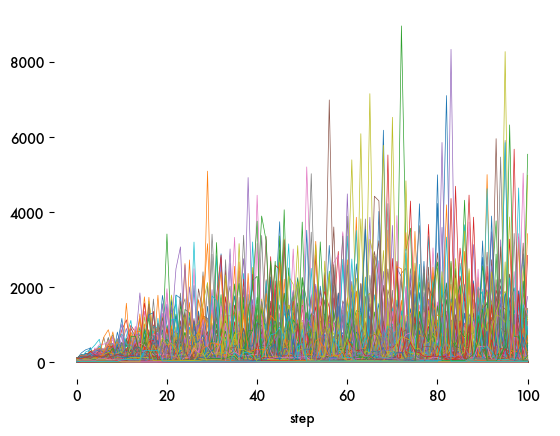

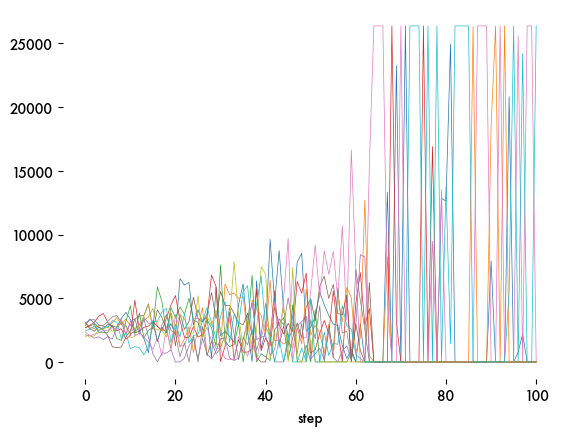

In [14]:
customer_wide = pd.pivot_table(customer_history, index = ['step'], values = ['balance'], columns = ['id'])
customer_wide.plot(linewidth=.5, legend=None)
sns.despine(left = True, bottom = True)
plt.show()

bank_wide = pd.pivot_table(bank_history, index = ['step'], values = ['reserves'], columns = ['id'])
bank_wide.plot(linewidth=.5, legend=None)
sns.despine(left = True, bottom = True)

These plots show the distribution of customer bank balances at the beginning of the simuation and the mean values at the end of the simulation steps.

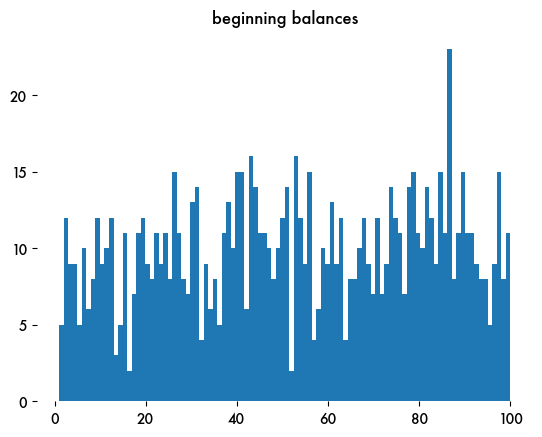

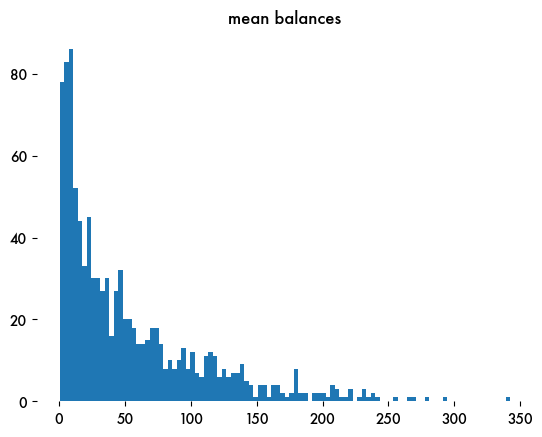

In [15]:
customer_history[customer_history['step'] == 0].hist('balance', bins = 100, grid=False)
plt.title('beginning balances')
sns.despine(left = True, bottom = True)
plt.show()

customer_history.groupby('id').mean().hist('balance', bins = 100, grid=False)
plt.title('mean balances')
sns.despine(left = True, bottom = True)

This new plot shows the movement of the market overnight rate over time.

,step,average_net_position,avg_daily_rate,average_risk_appetite,fed_recapitalization
0,0,0.000000,0.000000,0.00000,None
1,1,-0.002929,0.000000,0.28261,None
2,2,-0.003229,0.000000,0.28261,None
3,3,-0.001319,0.000000,0.28261,None
4,4,-0.003512,0.000000,0.28261,None
...,...,...,...,...,...
96,96,-9260.211920,0.599990,0.28261,None
97,97,-4753.543230,0.599978,0.28261,None
98,98,-7395.870752,0.599982,0.28261,None
99,99,-10744.717586,0.599992,0.28261,None


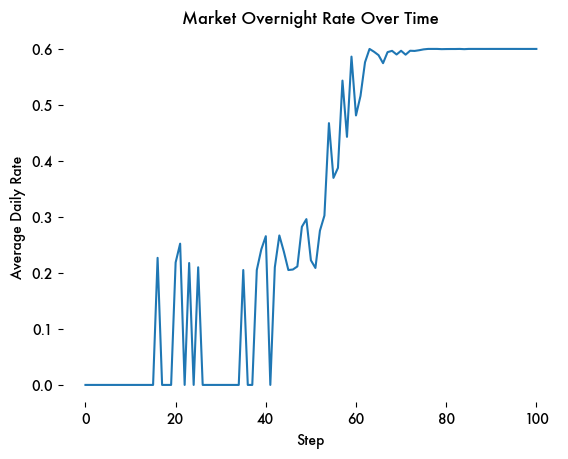

In [16]:
from IPython.display import display

display(financial_system_history)

plt.figure()
plt.plot(financial_system_history['step'], financial_system_history['avg_daily_rate'])
plt.title('Market Overnight Rate Over Time')
plt.xlabel('Step')
plt.ylabel('Average Daily Rate')
sns.despine(left=True, bottom=True)
plt.show()

This final plot shows, for each bank, mean reserve and loan values.

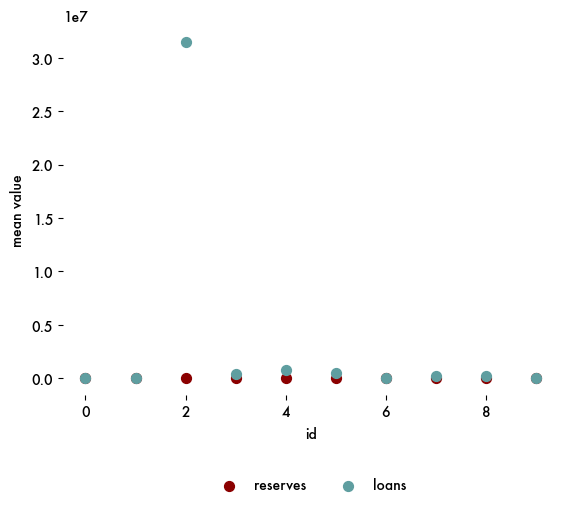

In [17]:
bank_means = bank_history[['id', 'reserves', 'loans']].groupby(by='id').mean()
bank_means = bank_means.reset_index()
ax = bank_means.plot.scatter(x = 'id', y = 'reserves', c = 'darkred', label = 'reserves', s = 50)
bank_means.plot.scatter(x = 'id', y = 'loans', c = 'cadetblue', label = 'loans', facecolors='none', s = 50, ax = ax)
plt.ylabel('mean value')
plt.legend(frameon=False, bbox_to_anchor=(0.5, -.3), loc='lower center', ncol=2)
sns.despine(left = True, bottom = True)

Letʻs see if we can discern what is happening with an animated plot

In [18]:
bank_history_output = widgets.Output()

def plot_bank_reserves_history():
    """Create an animated bar chart of bank reserves ordered by risk appetite"""
    with bank_history_output:
        clear_output(wait=True)
        plt.close('all')  # Close any existing figures
        
        # Create figure for animation
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Sort banks by risk appetite
        sorted_indices = sorted(range(len(risk_appetites)), key=lambda k: risk_appetites[k])
        sorted_appetites = [risk_appetites[i] for i in sorted_indices]
        
        # Calculate y-axis limits once
        all_reserves = [r for step_data in bank_history.groupby('step')['reserves'] for r in step_data[1]]
        y_min = min(all_reserves)
        y_max = min(50000, max(all_reserves))
        
        def update(frame):
            ax.clear()
            step_data = bank_history[bank_history['step'] == frame]
            
            # Get reserves for this step, sorted by risk appetite
            reserves = [step_data[step_data['id'] == i]['reserves'].values[0] for i in sorted_indices]
            
            # Create bar plot with color gradient
            colors = plt.cm.viridis(np.linspace(0, 1, len(reserves)))
            bars = ax.bar(range(len(reserves)), reserves, color=colors)
            
            # Set static y-axis limits
            ax.set_ylim(y_min, y_max)
            
            # Customize the plot
            ax.set_title(f'Bank Reserves by Risk Appetite (Step {frame})')
            ax.set_xlabel('Banks (ordered by risk appetite)')
            ax.set_ylabel('Reserves')
            
            # Set x-ticks to show risk appetites
            ax.set_xticks(range(len(sorted_appetites)))
            ax.set_xticklabels([f'{a:.2f}' for a in sorted_appetites], rotation=45)
            
            sns.despine(left=True, bottom=True)
            plt.tight_layout()
        
        # Create animation
        global bank_history_anim
        bank_history_anim = animation.FuncAnimation(
            fig,
            update,
            frames=bank_history['step'].unique(),
            interval=200,
            repeat=False
        )
        
        # Display the animation
        display(HTML(bank_history_anim.to_jshtml()))
        plt.close()



# autorun animation
display(bank_history_output)
plot_bank_reserves_history()




Output()